# ASTR 596: The Final

#### Three questions, each worth a third of your grade. (I'll make one 34 pts to get to an even 100). Each is designed to test an area where I think the class as a whole is less comfortable. They are sorted by my assesment of difficulty from easiest to hardest. 
#### i.e. the last is probably going to be non-trivial, because well I like Gaussian distributions of grades. 
#### That's OK because the points and grades don't matter!

#### Remember, you can work together, discuss problems and solutions, but you have to write up your own solution. I'd strongly suggest doing that, ideally with some divide and conquer strategy.

### Q1. Using unsupervised learning to work with galaxies

The following query will select 20k likely galaxies from the SDSS database and return the results of that query into an `astropy Table`.  (For now, if you are not familiar with the SDSS DB schema, don't worry about this query, just know that it returns a bunch of photometric features.)

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.sdss import SDSS  # enables direct queries to the SDSS database
from scipy.stats import zscore
import seaborn as sns

In [2]:
GALquery = """SELECT TOP 20000 
         p.dered_u - p.dered_g as ug, p.dered_g - p.dered_r as gr, 
         p.dered_g - p.dered_i as gi, p.dered_g - p.dered_z as gz,             
         p.petroRad_i, p.petroR50_i, p.deVAB_i, p.fracDev_i
         FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
         WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND p.type = 3
         AND p.deVAB_i > -999 AND p.petroRad_i > -999 AND p.petroR50_i > -999 AND p.dered_r < 20
           """
SDSSgals = SDSS.query_sql(GALquery).to_pandas()

# Remove rows with bad data (5 rows)
inds = np.full(len(SDSSgals), True, dtype=bool)
for col in ['ug', 'gr', 'gi', 'gz']:
    inds &= (SDSSgals[col] > -10000)
SDSSgals = SDSSgals[inds]

# Remove 5σ outliers
SDSSgals = SDSSgals[(np.abs(zscore(SDSSgals)) < 5).all(axis=1)].reset_index(drop=True)

SDSSgals

ug        gr        gi        gz  petroRad_i  petroR50_i  \
0      1.102777  0.612753  0.966055  1.245878    3.806186    1.850212   
1      0.657669  0.901318  1.392420  1.791269    2.491137    1.227186   
2      2.501947  0.992634  1.423307  1.763699    3.405268    1.593328   
3      1.544609  1.490404  2.037325  2.326193    2.611695    1.255236   
4      1.328907  0.580282  0.903484  1.097187    5.837022    2.827120   
...         ...       ...       ...       ...         ...         ...   
19872  1.987646  0.861901  1.263277  1.567926    4.128296    1.846510   
19873  1.774546  0.764725  1.149637  1.414255    2.833095    1.305070   
19874  2.127468  0.945520  1.407134  1.733912    4.843205    2.066179   
19875  2.036207  1.204462  1.655436  1.988209    2.150444    1.040920   
19876  2.025269  1.002871  1.409067  1.753242    5.153855    2.102165   

        deVAB_i  fracDev_i  
0      0.378152   0.412818  
1      0.843788   0.483995  
2      0.241452   0.610370  
3      0.979357   1.000000  
4      0.430816   0.000000  
...         ...        ...  
19872  0.435777   0.825134  
19873  0.732343   0.915611  
19874  0.696406   1.000000  
19875  0.324291   1.000000  
19876  0.963789   1.000000  

[19877 rows x 8 columns]

### 1a - Visualize the dataset in g-i (y) vs u-g (x) and all the features (11 pts). 

The bluest galaxies are star-forming galaxies at low redshift 𝑧. The "tight" cluster of red galaxies are passive galaxies at low-𝑧. Finally the diffuse cloud at 𝑔−𝑖≈3 are high-𝑧 luminous red galaxies (LRGs) that were targeted for BAO measurements. These sources have a wide range of 𝑢−𝑔 colors because they essentially are not detected in the 𝑢 band as this is blueward of the Lyman break.

Plot and examine each of the features in this data set using seaborn's `PairGrid`. Overlay a histogram and kernel density distribution (KDE) on each 1D and 2D plot. You should be able to roughly see the different groups of galaxies, but how to separate them?

In [3]:
SDSSgals.describe([0.01, 0.25, 0.5, 0.75, 0.99])

ug            gr            gi            gz    petroRad_i  \
count  19877.000000  19877.000000  19877.000000  19877.000000  19877.000000   
mean       1.897296      1.119084      1.625908      1.950469      4.843579   
std        0.900589      0.462189      0.620509      0.704148      2.524870   
min       -0.787283     -0.474628     -0.914656     -1.022850      1.079102   
1%         0.314085      0.242253      0.453125      0.510179      1.741346   
25%        1.350626      0.790203      1.189804      1.482107      3.288214   
50%        1.797552      1.008171      1.456049      1.806656      4.238905   
75%        2.081444      1.567808      2.231148      2.606510      5.617043   
99%        5.202986      1.963564      2.829822      3.330908     14.739124   
max        6.495335      3.060507      4.313847      4.644924     32.939220   

         petroR50_i       deVAB_i     fracDev_i  
count  19877.000000  19877.000000  19877.000000  
mean       2.081702      0.659553      0.749345  
std        0.957091      0.207505      0.339670  
min        0.281451      0.050000      0.000000  
1%         0.857575      0.165533      0.000000  
25%        1.471776      0.523011      0.552124  
50%        1.833823      0.691130      0.955232  
75%        2.416719      0.819483      1.000000  
99%        5.772531      0.999791      1.000000  
max        9.203894      1.000000      1.000000

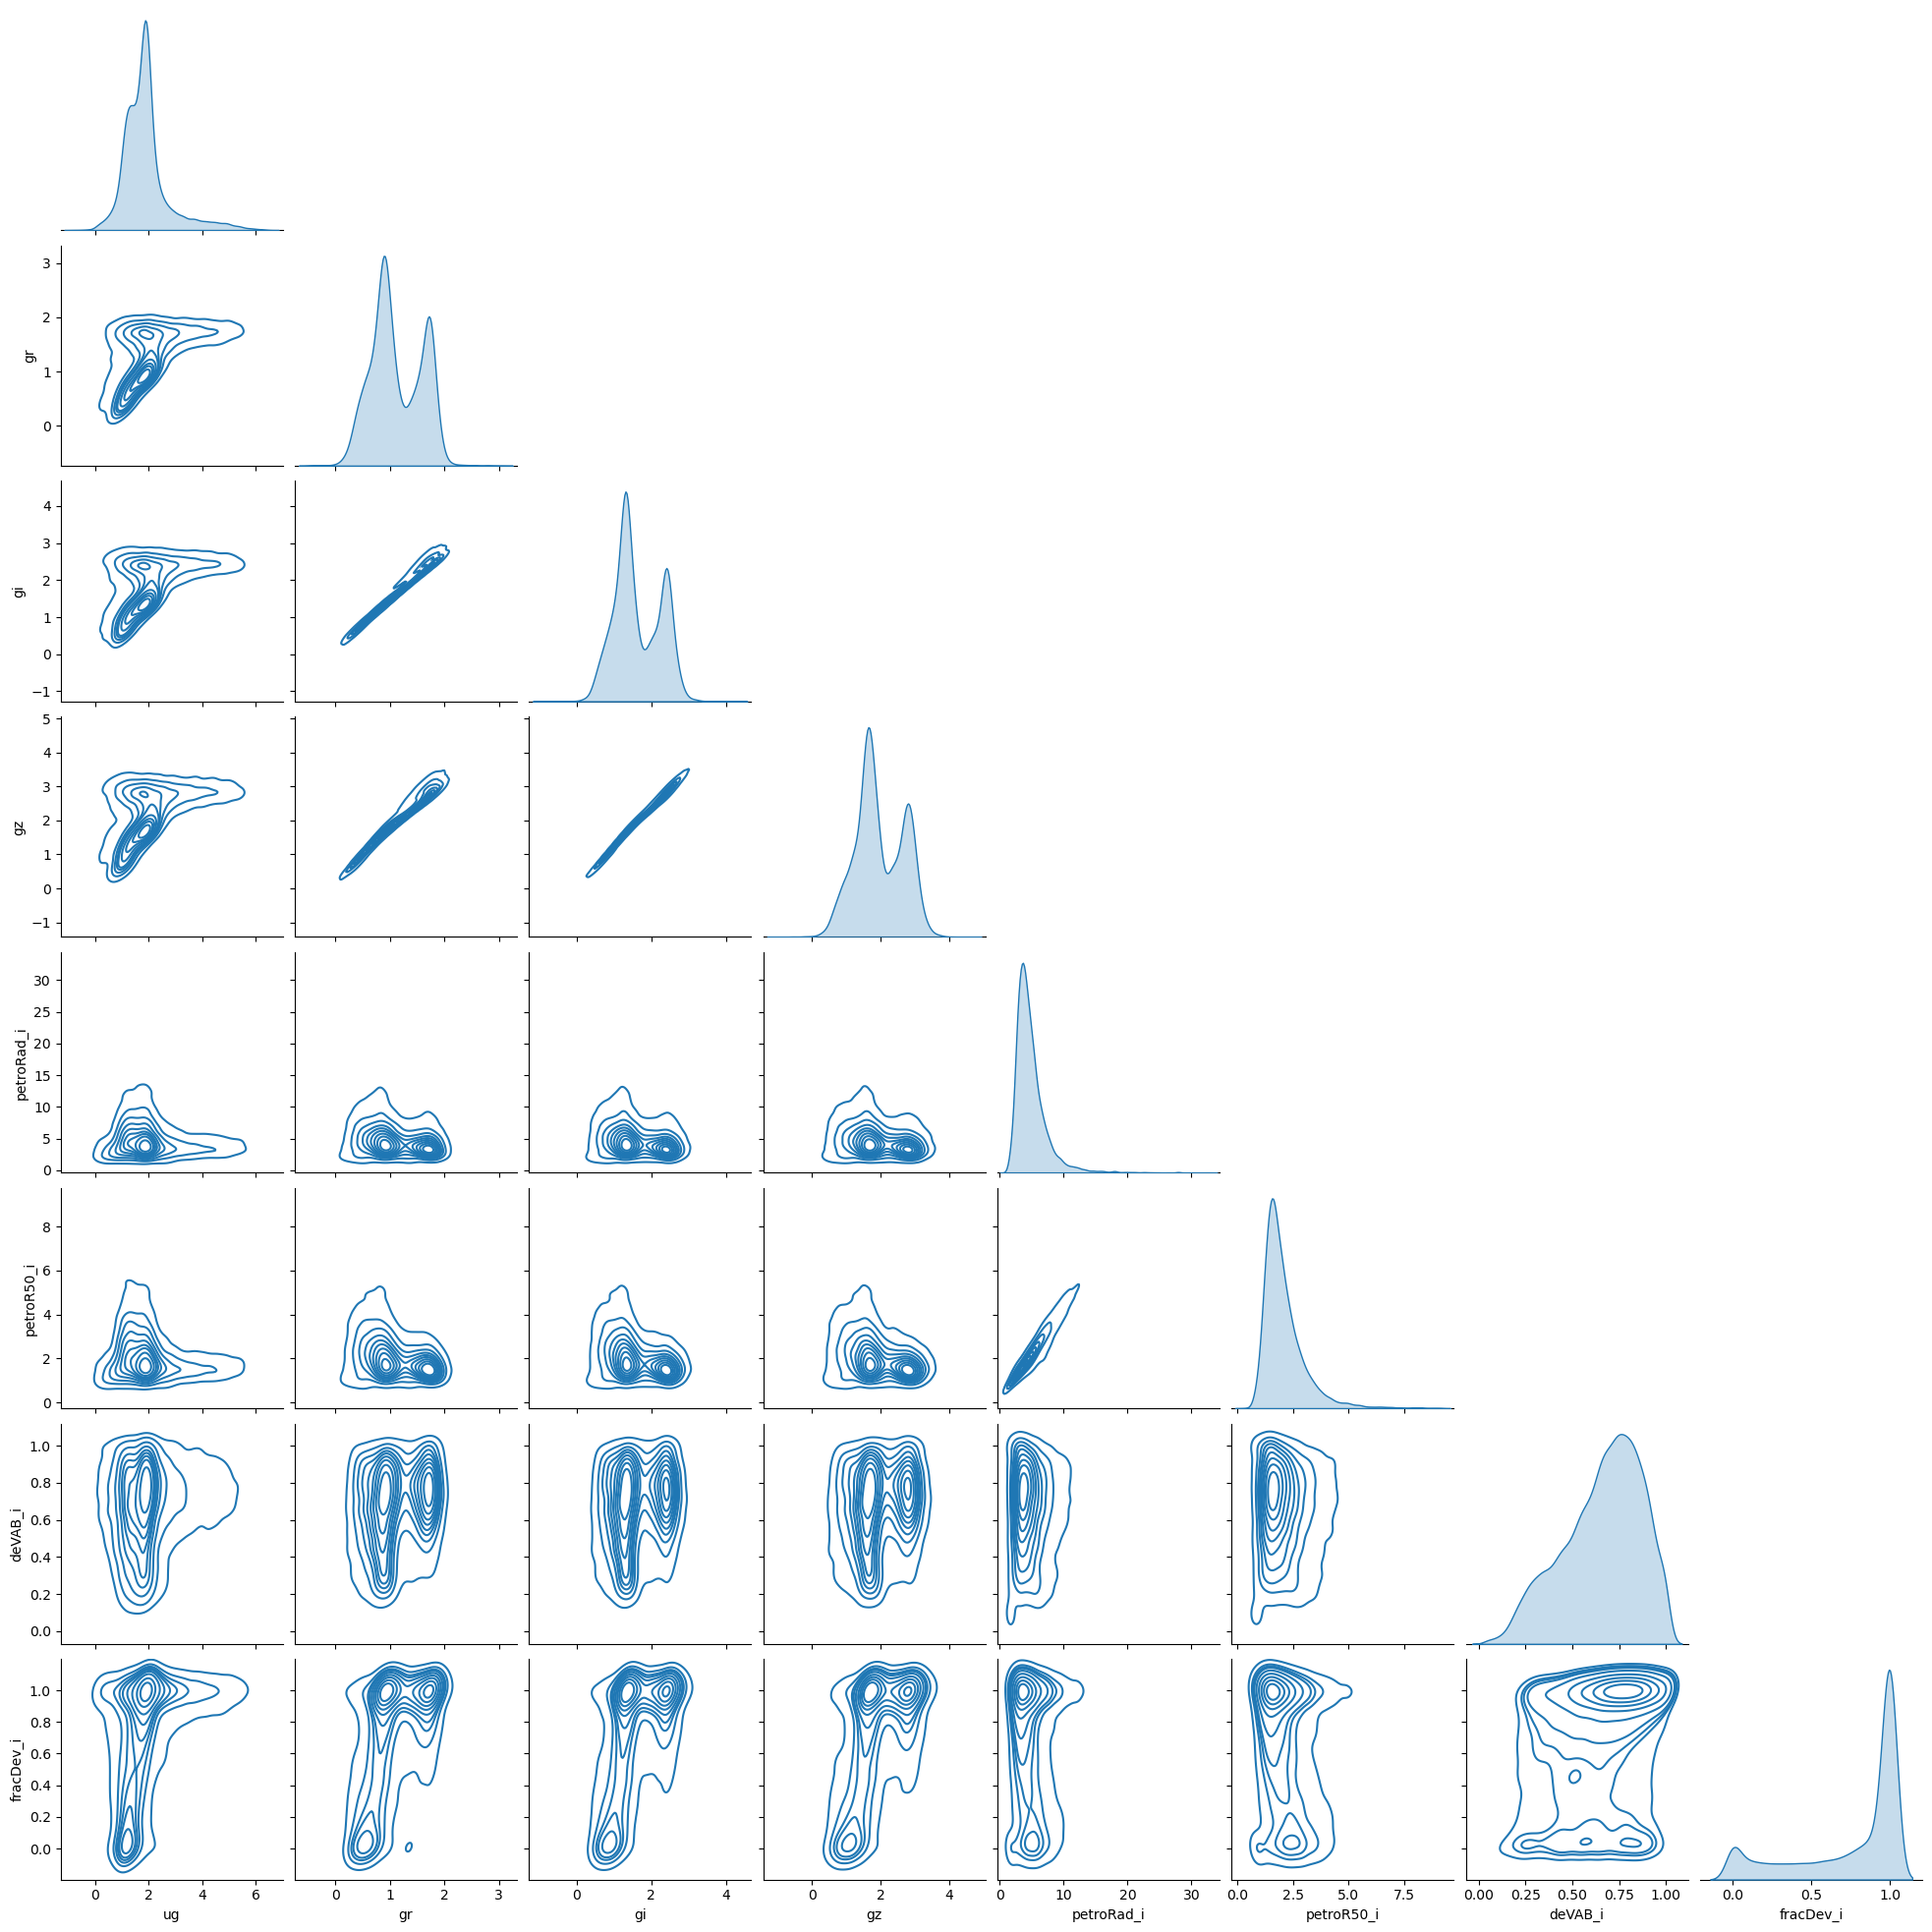

In [4]:
grid = sns.pairplot(SDSSgals, kind='kde', corner=True)
plt.show()

<span style="color: DodgerBlue">

The distributions of `gr`, `gi`, `gz`, and `fracDev_i` appear to have two peaks, while the others appear to have one. We can see three peaks in the `gr`-`fracDev_i`, `gi`-`fracDev_i`, and `gz`-`fracDev_i` spaces, which means that there are likely three groups, as expected.

</span>

### 1b - Separating the galaxy types (11 pts) 

Using K-means from `sklearn` with n=3, separate the three clusters of galaxies. Initial guesses, hyper-paramter tuning, dimensionality reduction etc are your choices. What's important is to be able to justify them. To the referee, to me, to yourself. We'll do that in the next part. 

In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [6]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(SDSSgals)

kmeans = KMeans(n_clusters=3, n_init=10, tol=1e-8)
kmeans.fit(scaled_data)

colors = [f'C{i}' for i in kmeans.labels_]

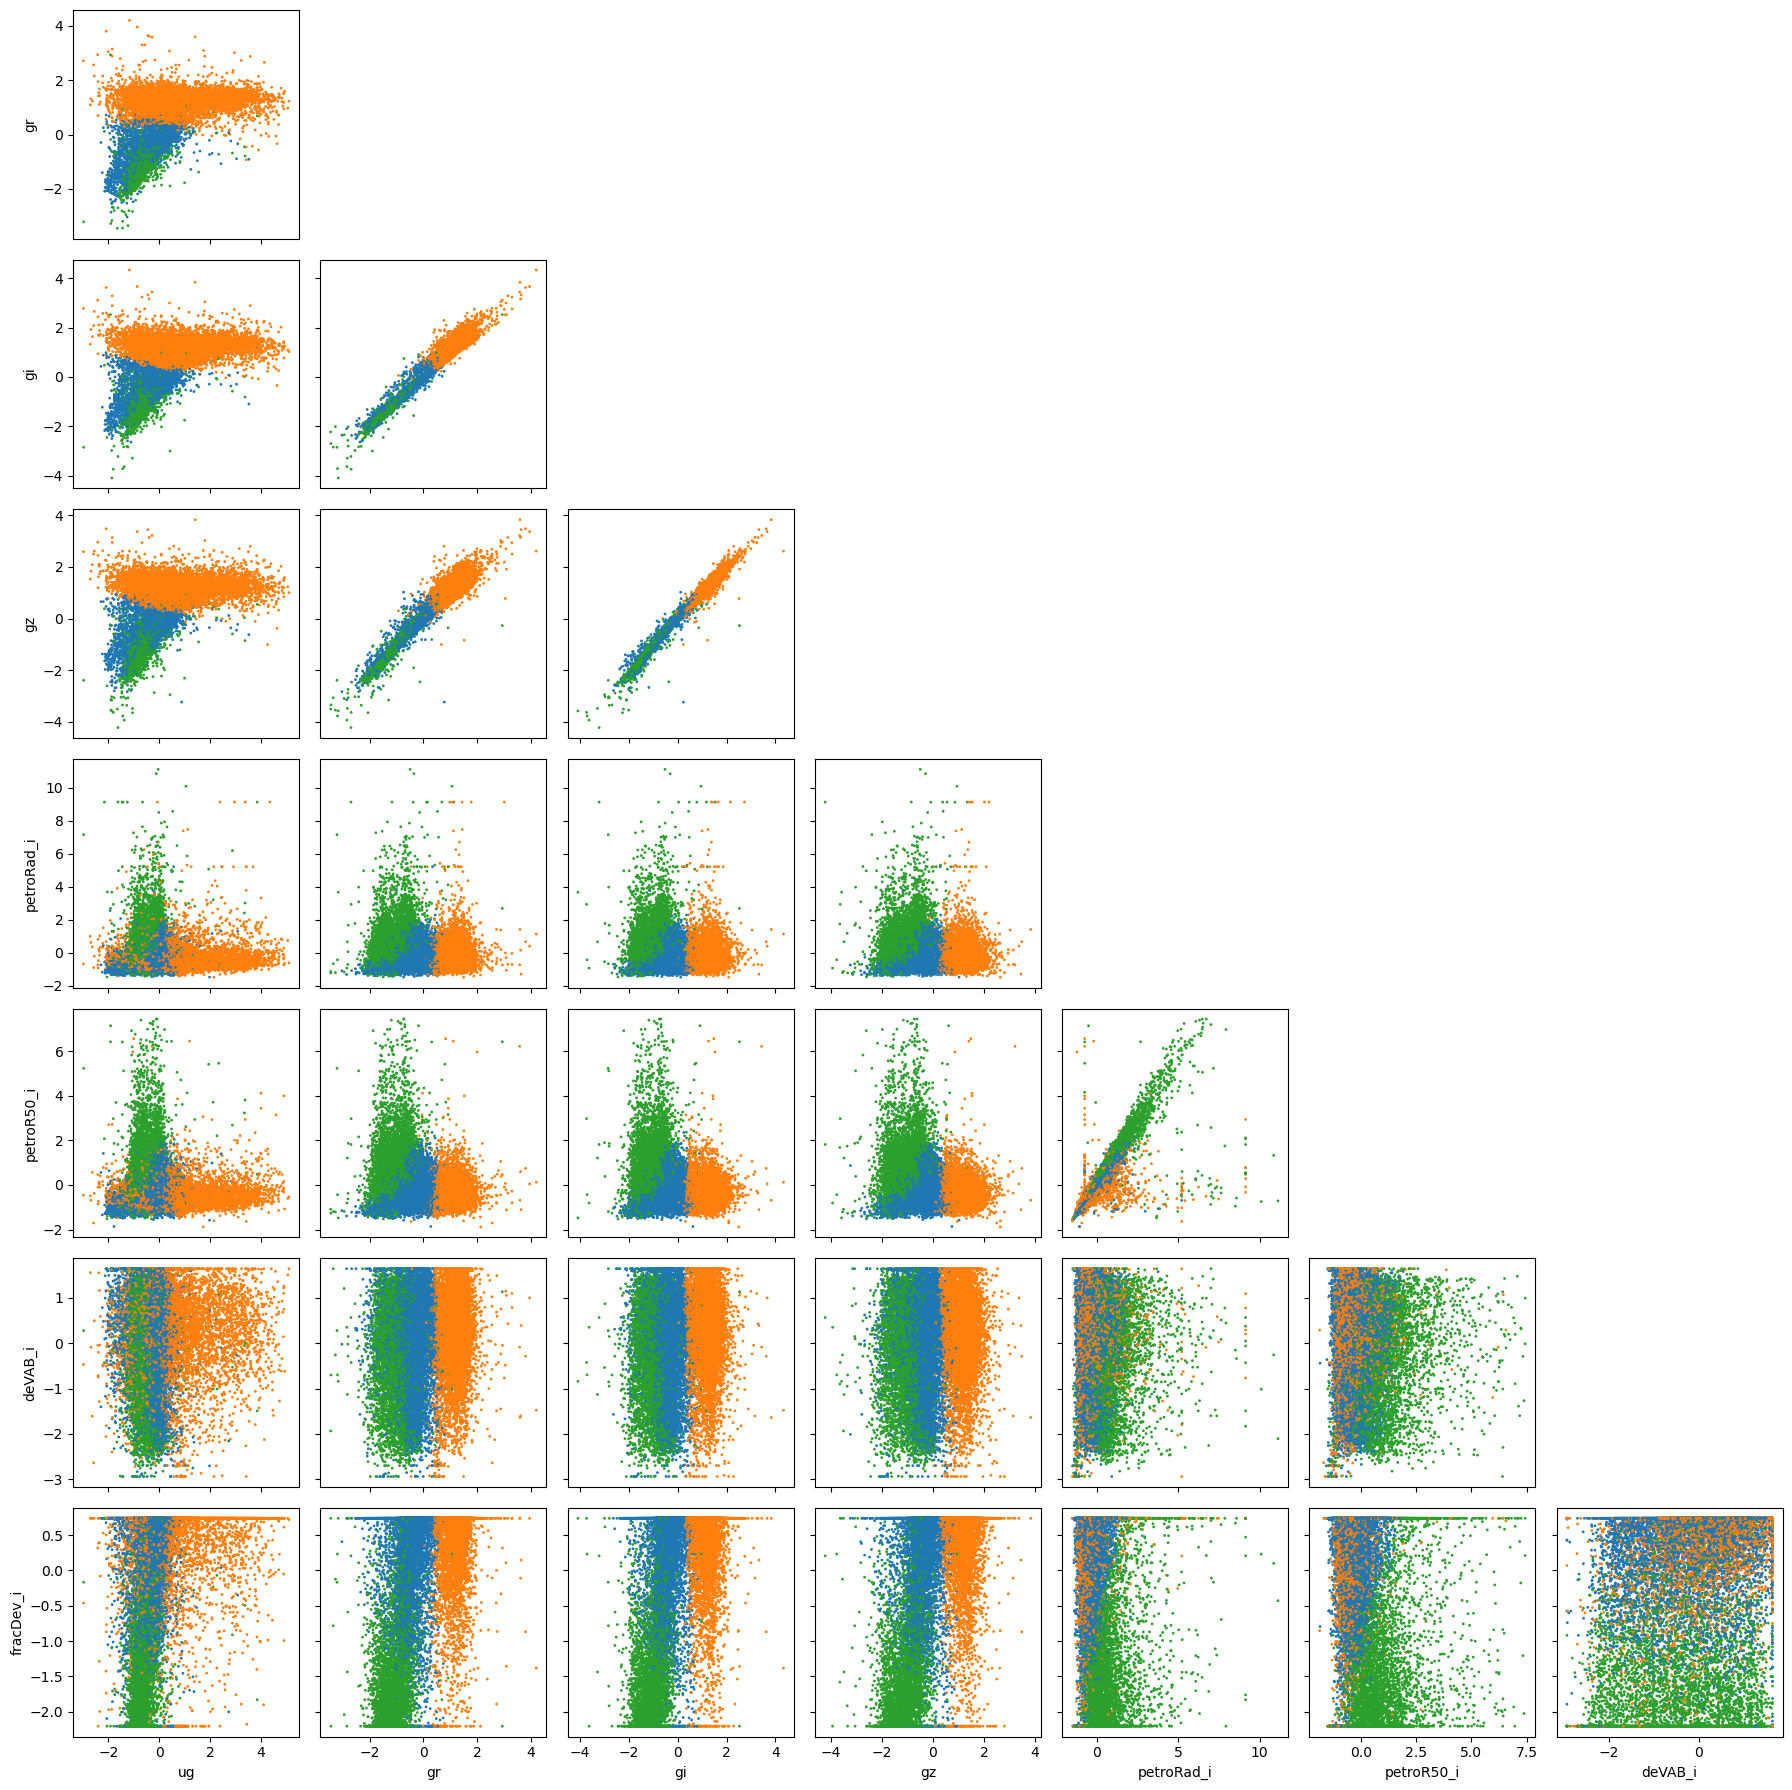

In [7]:
fig, axes = plt.subplots(7, 7, figsize=(18, 18), sharex='col', sharey='row')
for i in range(1, 8):
    for j in range(7):
        if i <= j:
            axes[i-1, j].axis('off')
        else:
            axes[i-1, j].scatter(scaled_data[:, j], scaled_data[:, i], s=1, c=colors)
for i in range(7):
    axes[i, 0].set_ylabel(SDSSgals.columns[i+1])
for j in range(7):
    axes[-1, j].set_xlabel(SDSSgals.columns[j])

plt.tight_layout()
plt.show()

### 1c - Working with the distributions (11 pts)
Repeat 1a, but using the results of K-means in 1b to create separately colored distributions for your different classes of galaxies. Use the KDE to provide the mean values of each feature and their standard deviation (hint - these are integrals), and compare them to the sample means and standard deviations. 

In [8]:
SDSSgals_labeled = SDSSgals.assign(label=kmeans.labels_)
SDSSgals_labeled

ug        gr        gi        gz  petroRad_i  petroR50_i  \
0      1.102777  0.612753  0.966055  1.245878    3.806186    1.850212   
1      0.657669  0.901318  1.392420  1.791269    2.491137    1.227186   
2      2.501947  0.992634  1.423307  1.763699    3.405268    1.593328   
3      1.544609  1.490404  2.037325  2.326193    2.611695    1.255236   
4      1.328907  0.580282  0.903484  1.097187    5.837022    2.827120   
...         ...       ...       ...       ...         ...         ...   
19872  1.987646  0.861901  1.263277  1.567926    4.128296    1.846510   
19873  1.774546  0.764725  1.149637  1.414255    2.833095    1.305070   
19874  2.127468  0.945520  1.407134  1.733912    4.843205    2.066179   
19875  2.036207  1.204462  1.655436  1.988209    2.150444    1.040920   
19876  2.025269  1.002871  1.409067  1.753242    5.153855    2.102165   

        deVAB_i  fracDev_i  label  
0      0.378152   0.412818      2  
1      0.843788   0.483995      0  
2      0.241452   0.610370      0  
3      0.979357   1.000000      1  
4      0.430816   0.000000      2  
...         ...        ...    ...  
19872  0.435777   0.825134      0  
19873  0.732343   0.915611      0  
19874  0.696406   1.000000      0  
19875  0.324291   1.000000      0  
19876  0.963789   1.000000      0  

[19877 rows x 9 columns]

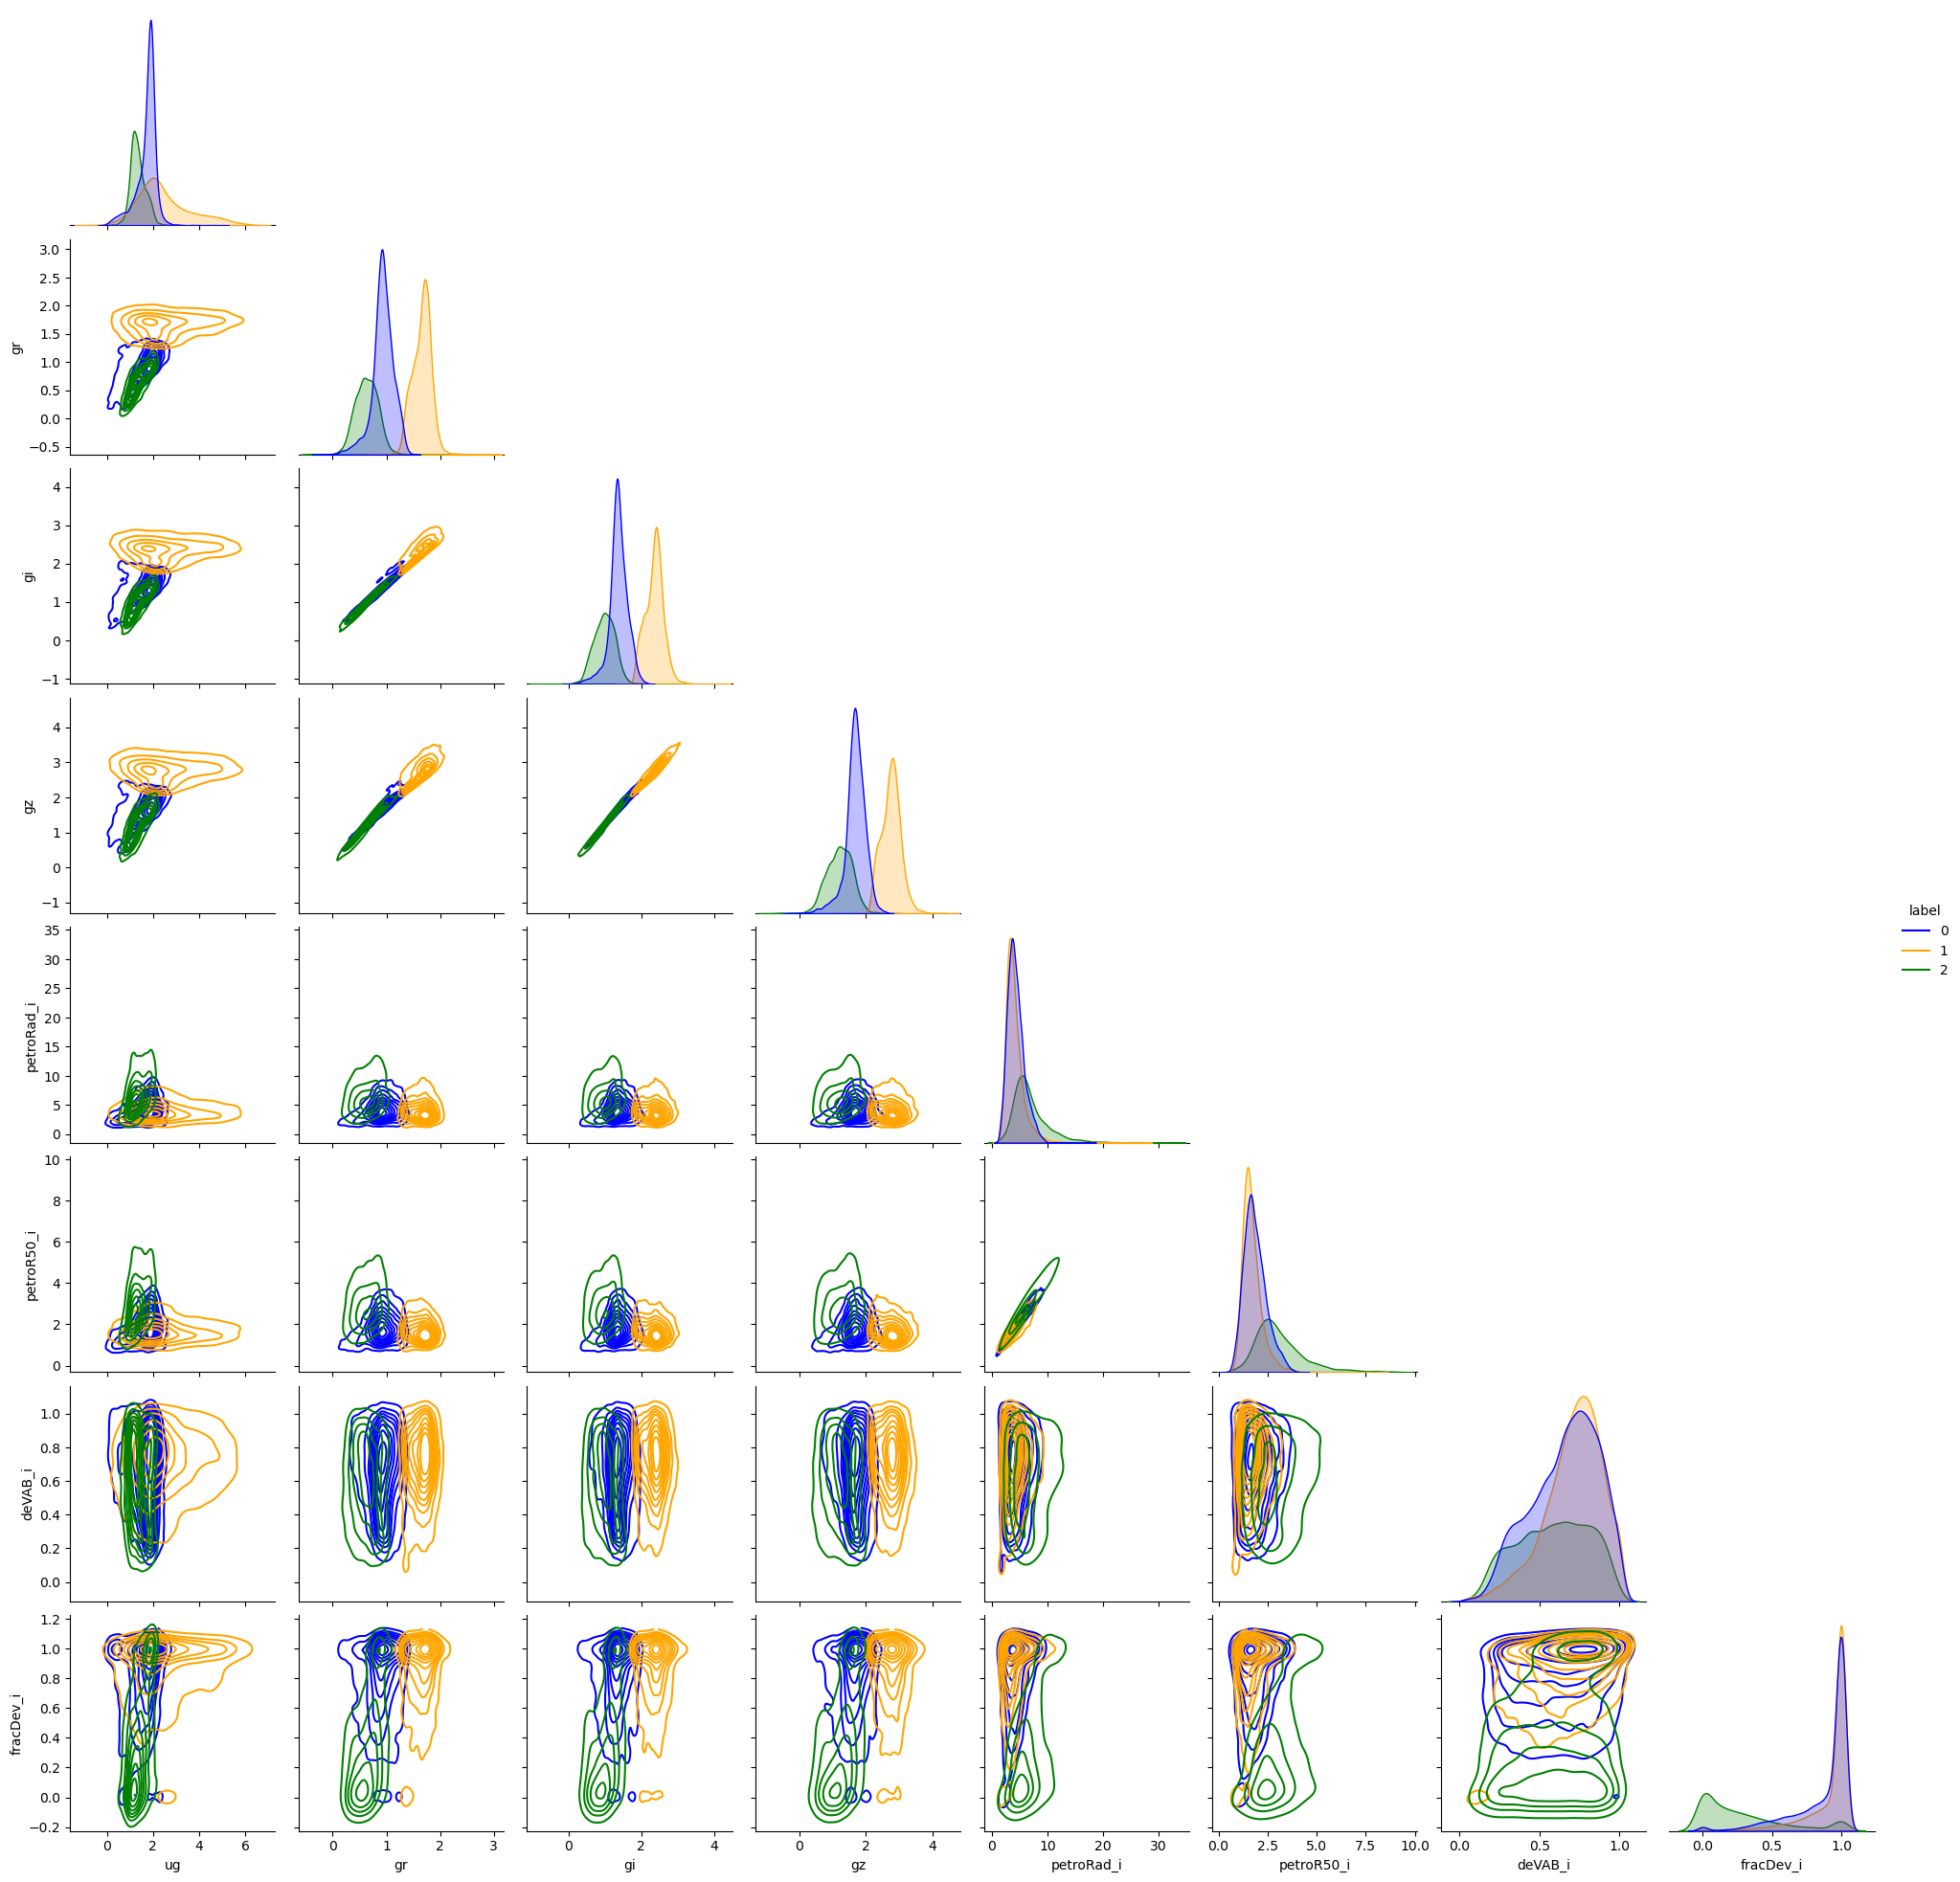

In [9]:
pairgrid = sns.pairplot(SDSSgals_labeled, hue='label', kind='kde', corner=True,
                        palette={0: 'Blue', 1: 'Orange', 2: 'Green'})
plt.show()

In [10]:
from sklearn.neighbors import KernelDensity
from scipy.integrate import quad

In [11]:
kde = KernelDensity(bandwidth='scott')

def pdf(x):
    return np.exp(kde.score_samples([[x]])[0])

features = ['ug', 'gr', 'gi', 'gz', 'petroRad_i', 'petroR50_i', 'deVAB_i', 'fracDev_i']
kde_means = dict(zip(features, [{} for i in features]))
kde_vars  = dict(zip(features, [{} for i in features]))
sample_means = dict(zip(features, [{} for i in features]))
sample_vars  = dict(zip(features, [{} for i in features]))

for feature in features:
    for label in (0, 1, 2):
        inds = (SDSSgals_labeled['label'] == label)
        kde.fit(np.array(SDSSgals_labeled[feature][inds])[:, None])
        
        mean = quad(lambda x: x * pdf(x), -np.inf, np.inf, limit=1000)[0]
        var  = quad(lambda x: (x - mean)**2 * pdf(x), -np.inf, np.inf, limit=1000)[0]
        
        kde_means[feature][label] = mean
        kde_vars[feature][label]  = var
        sample_means[feature][label] = SDSSgals_labeled[feature][inds].mean()
        sample_vars[feature][label]  = SDSSgals_labeled[feature][inds].var()

In [21]:
line = ' | '.join(['Feature'.center(10), 'Label', 'KDE Mean', 'Sample Mean', 'KDE Var', 'Sample Var'])
print(line)
print('-' * len(line))
for feature in features:
    for label in (0, 1, 2):
        kde_mean = kde_means[feature][label]
        kde_var  = kde_vars[feature][label]
        sample_mean = sample_means[feature][label]
        sample_var  = sample_vars[feature][label]
        
        feature_str = feature if label == 0 else ''
            
        print(' | '.join([feature_str.rjust(10), str(label).rjust(5),
                          f'{kde_mean:.4f}'.rjust(8), f'{sample_mean:.4f}'.rjust(11),
                          f'{kde_var:.4f}'.rjust(7), f'{sample_var:.4f}'.rjust(10)]))
    

 Feature   | Label | KDE Mean | Sample Mean | KDE Var | Sample Var
------------------------------------------------------------------
        ug |     0 |   1.7130 |      1.7130 |  0.2225 |     0.1954
           |     1 |   2.4689 |      2.4689 |  1.4350 |     1.4063
           |     2 |   1.3441 |      1.3441 |  0.1639 |     0.1295
        gr |     0 |   0.9287 |      0.9287 |  0.0691 |     0.0420
           |     1 |   1.6579 |      1.6579 |  0.0618 |     0.0329
           |     2 |   0.6279 |      0.6279 |  0.0822 |     0.0478
        gi |     0 |   1.3603 |      1.3603 |  0.0944 |     0.0673
           |     1 |   2.3526 |      2.3526 |  0.0949 |     0.0660
           |     2 |   0.9796 |      0.9796 |  0.1256 |     0.0912
        gz |     0 |   1.6763 |      1.6763 |  0.1259 |     0.0988
           |     1 |   2.7533 |      2.7533 |  0.1166 |     0.0878
           |     2 |   1.2015 |      1.2015 |  0.1862 |     0.1518
petroRad_i |     0 |   4.2671 |      4.2671 |  2.2665 |     2.

<span style="color: DodgerBlue">

The KDE means match the sample means very well, while the KDE variances are all about $\sim0.03$ units larger than the sample variances. This is probably not a coincidence, but I don't know why this occurs.

</span>

### Q2. Gaussian Processes + Emcee

There are many sources with periodic light curves that are not strictly sinusoidal. Thus, the use of the cosine kernel (on its own) may not be sufficient to model the signal. The quasi-periodic kernel: 

$$K_{ij} = k(x_i - x_j) = A \exp \left(-\Gamma \sin^2\left[\frac{\pi}{P} \left|x_i - x_j\right|\right]\right)$$

is useful for non-sinusoidal signals. It is implemented in the `george` package. Note that the parameters in the kernel aren't the only parameters you might need... look back on your previous homework assignments and think about what I'm glossing over here. 

I've given you an example light curve file with a decidedly non-sinusoidal, periodic signal from the ASAS-SN project from our colleagues at OSU. 

### 2a - Implement the model  (11 pts)

Examine this data, filter it as you see fit (I've included the file header in full - I'd pick one aperture, and look at the grades and notes about separate datasets). You can make tradeoffs here - more data that is potentially messier, vs less data so weaker constraints, but cleaner. Pick something that you can justify (and if you're struggling at 2c, examine this choice before twiddling with emcee). 

Write down a model for it with the likelihood function, an appropriate prior and posterior.

You may wish to look at the `george` documentation again, particularly how some parameters are better log transformed if the expectation is that they are positive real values. 

https://george.readthedocs.io/en/latest/tutorials/model/

In [2]:
tab = pd.read_csv('asas_data.dat', delim_whitespace=True, comment='#', header=None,
                  names=('HJD', 'MAG_10?', 'MAG_01?', 'MAG_2', 'MAG_3', 'MAG_4',
                         'MER_10?', 'MER_01?', 'MER_2', 'MER_3', 'MER_4', 'GRADE', 'FRAME'))

inds = (tab['MAG_4'] < 29.999) & (tab['GRADE'] == 'A')
tab = tab[inds][['HJD', 'MAG_4', 'MER_4']]
tab.rename(columns={'MAG_4': 'MAG', 'MER_4': 'MER'}, inplace=True)
tab.sort_values('HJD', inplace=True, ignore_index=True)

tab

HJD     MAG    MER
0    1868.76113  12.193  0.046
1    1869.74854  12.190  0.037
2    1869.75808  12.247  0.049
3    1870.77105  11.820  0.048
4    1871.78921  12.176  0.049
..          ...     ...    ...
984  5042.92542  12.358  0.055
985  5086.87177  11.871  0.051
986  5098.88785  12.142  0.053
987  5165.75062  11.864  0.055
988  5166.74107  12.278  0.062

[989 rows x 3 columns]

In [3]:
tab.describe()

HJD         MAG         MER
count   989.000000  989.000000  989.000000
mean   3444.223343   11.985611    0.035044
std     917.872295    0.301727    0.009252
min    1868.761130   11.344000    0.015000
25%    2688.687050   11.729000    0.029000
50%    3495.549580   12.051000    0.036000
75%    4231.508660   12.232000    0.042000
max    5166.741070   13.481000    0.062000

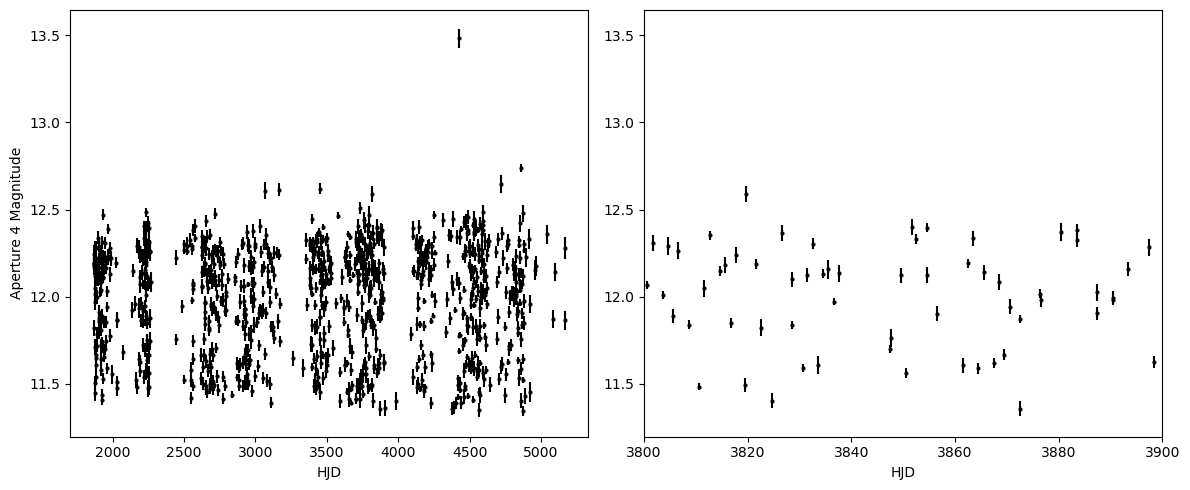

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax in axes:
    ax.errorbar(tab['HJD'], tab['MAG'], tab['MER'], fmt='o', ms=2, color='Black')
    ax.set_xlabel('HJD')
axes[0].set_ylabel('Aperture 4 Magnitude')
axes[1].set_xlim(3800, 3900)
plt.tight_layout()
plt.show()

<span style="color: DodgerBlue">

From the full plot (left), we can see that the period is short compared to the entire duration, probably on the order of a few days. Zooming in on a specific interval (right) confirms this rough prediction. To be more precise, it is helpful to use a periodogram. I will look at periods ranging from $0.1$ days to $10$ days.

</span>

In [5]:
from astropy.timeseries import LombScargle
from scipy.signal import find_peaks

Top 8 Periods:
Period = 0.7371 d, Power = 0.6133
Period = 1.5478 d, Power = 0.4160
Period = 2.8256 d, Power = 0.3771
Period = 0.4239 d, Power = 0.3711
Period = 0.2977 d, Power = 0.2856
Period = 0.6065 d, Power = 0.1727
Period = 0.2294 d, Power = 0.1539
Period = 0.3775 d, Power = 0.1105


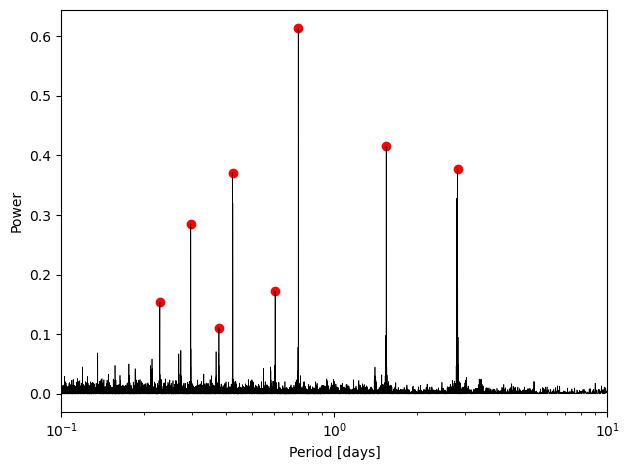

In [6]:
periods = np.logspace(-1, 1, 50_000)
power = LombScargle(tab['HJD'], tab['MAG'], tab['MER']).power(1 / periods)
peaks = find_peaks(power, height=0.1, distance=100)[0]

sorted_peak_inds = power[peaks].argsort()[::-1]
best_periods = periods[peaks][sorted_peak_inds]
best_powers = power[peaks][sorted_peak_inds]

print(f'Top {len(peaks)} Periods:')
for (per, pow) in zip(best_periods, best_powers):
    print(f'Period = {per:.4f} d, Power = {pow:.4f}')

fig, ax = plt.subplots()
ax.plot(periods, power, c='Black', lw=0.5)
ax.scatter(periods[peaks], power[peaks], c='Red')
ax.set_xlim(0.1, 10)
ax.set_xscale('log')
ax.set_xlabel('Period [days]')
ax.set_ylabel('Power')

plt.tight_layout()
plt.show()

In [7]:
import george
from george import kernels
from george.modeling import Model

<span style="color: DodgerBlue">

For the quasi-periodic kernel described in the problem, I choose initial parameter values of $A=1$, $\Gamma=10$, and $P=0.737$ days (the best Lomb-Scargle period). I plotted the GP predictions for this set of parameter values and it seems to have the right amplitude of variation. The period also looks sufficiently small to be able to recreate the observed trends. It could possibly be too small, but I don't have a good idea of how to check this aside from proceeding with the analysis.

To fully describe the lightcurve, we will also need to fit an offset, which I include below. According to the above plots, the offset should be somewhere around $\approx12$, and I choose to set it to the mean magnitude of the lightcurve.

</span>

In [8]:
kernel = 1 * kernels.ExpSine2Kernel(gamma=10, log_period=np.log(best_periods[0]))

class MyModel(Model):
    parameter_names = ('offset',)
    
    # Constant model
    def get_value(self, t):
        return np.full_like(t, self.offset)

gp = george.GP(kernel=kernel, mean=MyModel(offset=tab['MAG'].mean()), fit_mean=True)

print(gp.get_parameter_names())
print(gp.get_parameter_vector())

('mean:offset', 'kernel:k1:log_constant', 'kernel:k2:gamma', 'kernel:k2:log_period')
[11.98561072  0.         10.         -0.30500652]


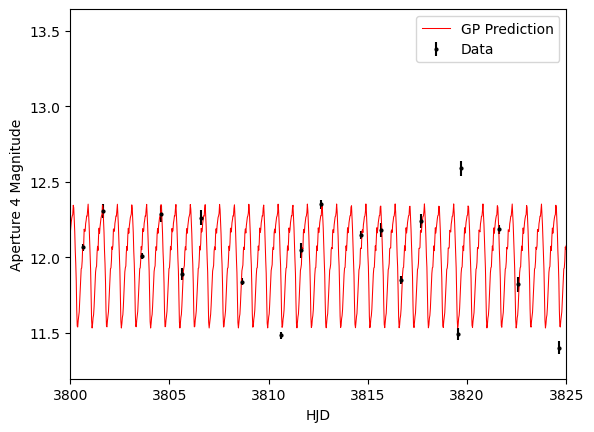

In [9]:
# Test the predictions of the GP for our initial parameter values
gp.compute(tab['HJD'], tab['MER'])

t_predict = np.linspace(3800, 3825, 1001)
prediction = gp.predict(tab['MAG'], t_predict, return_cov=False)

fig, ax = plt.subplots()
ax.errorbar(tab['HJD'], tab['MAG'], tab['MER'], fmt='o', ms=2, color='Black', label='Data')
ax.plot(t_predict, prediction, c='Red', lw=0.75, label='GP Prediction')
ax.set_xlabel('HJD')
ax.set_ylabel('Aperture 4 Magnitude')
ax.set_xlim(3800, 3825)
ax.legend()
plt.show()

<span style="color: DodgerBlue">

Next, I need to set priors on the parameters.

<ul>
  <li>
  
  From the periodogram, it seems okay to force the period to be in the range $0.1\text{--}10$ days. I will also apply a prior that is a sum of Gaussians in log-space centered on the 8 best Lomb-Scargle peaks, with standard deviations of $0.15$, and weighted by the power at that period. That is,
  $$
  f(P)=\frac{\sum_{i}\mathrm{Pow}_{i}\,G(\log(P);\log(P_{i}),0.15)}{\sum_{i}\mathrm{Pow}_{i}}.
  $$
  
  </li>
  <li>

  Since I am unsure about the values of $A$ and $\Gamma$, I will only enforce uniform priors of $-2\leq\log_{10}A\leq2$ and $-1\leq\log_{10}\Gamma\leq4$ on these parameters.
  
  </li>
  <li>

  For the offset, I will apply bounds of the minimum and maximum values attained in the lightcurve, and apply a Gaussian prior with mean and standard deviation equal to those of the lightcurve magnitudes.

  </li>
</ul>

</span>

In [10]:
data_min  = tab['MAG'].min()
data_max  = tab['MAG'].max()
data_mean = tab['MAG'].mean()
data_std  = tab['MAG'].std()
log_best_periods = np.log(best_periods)
best_powers_normalized = best_powers / np.sum(best_powers)

def gaussian(x, mu, sigma):
    return np.exp(-((x - mu) / sigma)**2 / 2) / np.sqrt(2 * np.pi) / sigma

def log_prior(theta):
    offset, logA, log10Gamma, logP = theta
    
    log10A = logA / np.log(10)
    P = np.exp(logP)
    
    # Uniform priors
    if not (data_min <= offset <= data_max):
        return -np.inf
    if not (-2 <= log10A <= 2):
        return -np.inf
    if not (-1 <= log10Gamma <= 4):
        return -np.inf
    if not (0.1 <= P <= 10):
        return -np.inf
    
    # Gaussian priors
    result = 0 
    result += np.log(gaussian(offset, data_mean, data_std))
    result += np.log(np.sum(best_powers_normalized * gaussian(logP, log_best_periods, 0.15)))
    
    return result

def log_prob(theta, y):
    offset, logA, log10Gamma, logP = theta
    
    gp.set_parameter_vector((offset, logA, 10**log10Gamma, logP))
    return gp.log_likelihood(y, quiet=True) + log_prior(theta)

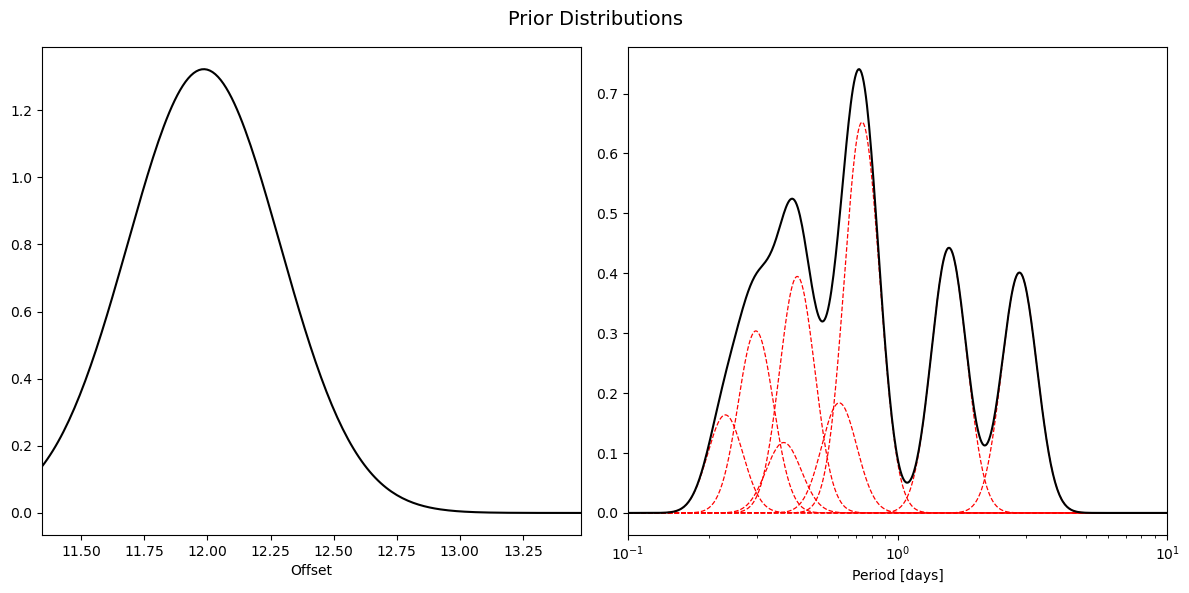

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axes

fig.suptitle('Prior Distributions', fontsize=14)

x1 = np.linspace(data_min, data_max, 200)
y1 = gaussian(x1, data_mean, data_std)
ax1.plot(x1, y1, c='Black')
ax1.set_xlim(data_min, data_max)
ax1.set_xlabel('Offset')

x2 = np.logspace(-1, 1, 500)
y2 = np.sum(best_powers_normalized * gaussian(np.log(x2[:, None]), log_best_periods, 0.15), axis=1)
for (log_per, pow_norm) in zip(log_best_periods, best_powers_normalized):
    ax2.plot(x2, pow_norm * gaussian(np.log(x2[:, None]), log_per, 0.15), c='Red', lw=0.9, ls='dashed')
ax2.plot(x2, y2, c='Black')
ax2.set_xlim(0.1, 10)
ax2.set_xscale('log')
ax2.set_xlabel('Period [days]')

plt.tight_layout()
plt.show()

### 2b - Initial Guesses (11 pts)

Make some initial guess for the parameters. For the period, use Lomb-Scargle to find the top three periods for this light curve. Initialize 1/3rd of the walkers to each of the top three periods

Do the burn in with `emcee` - a 100 walkers and a 1000 steps should be plenty - you should find that the walkers have migrated away from the starting guess. Plot the chains. 

Make a plot of the log of the Posterior vs the log of the Period - select the periods with the highest log Posterior and change the initial guess for the Period of all the walkers to be in a small region around the Period with the highest log Posterior. 

In [17]:
# Initialize walkers

n_walkers = 100

rng = np.random.default_rng(42)

#               offset     logA       log10Gamma    logP
tmp1 = np.tile([data_mean, np.log(1), np.log10(10), np.log(best_periods[0])], (n_walkers - 2 * (n_walkers // 3), 1))
tmp2 = np.tile([data_mean, np.log(1), np.log10(10), np.log(best_periods[1])], (n_walkers // 3, 1))
tmp3 = np.tile([data_mean, np.log(1), np.log10(10), np.log(best_periods[2])], (n_walkers // 3, 1))
initial_conditions = np.concatenate([tmp1, tmp2, tmp3])
initial_conditions += 1e-3 * rng.standard_normal(initial_conditions.shape)

In [18]:
import emcee
from multiprocess import Pool
import os

OMP_NUM_THREADS = os.environ['OMP_NUM_THREADS']
os.environ['OMP_NUM_THREADS'] = '1'

In [19]:
# Setup
n_dim    = 4
n_burnin = 1000

gp.compute(tab['HJD'], tab['MER'])

# Run burn-in
with Pool() as pool:
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_prob, args=(tab['MAG'],), pool=pool)
    sampler.run_mcmc(initial_conditions, n_burnin, progress=True)

burnin_samples = sampler.get_chain()
np.save('burnin_samples.npy', burnin_samples)

100%|██████████| 1000/1000 [45:53<00:00,  2.75s/it]


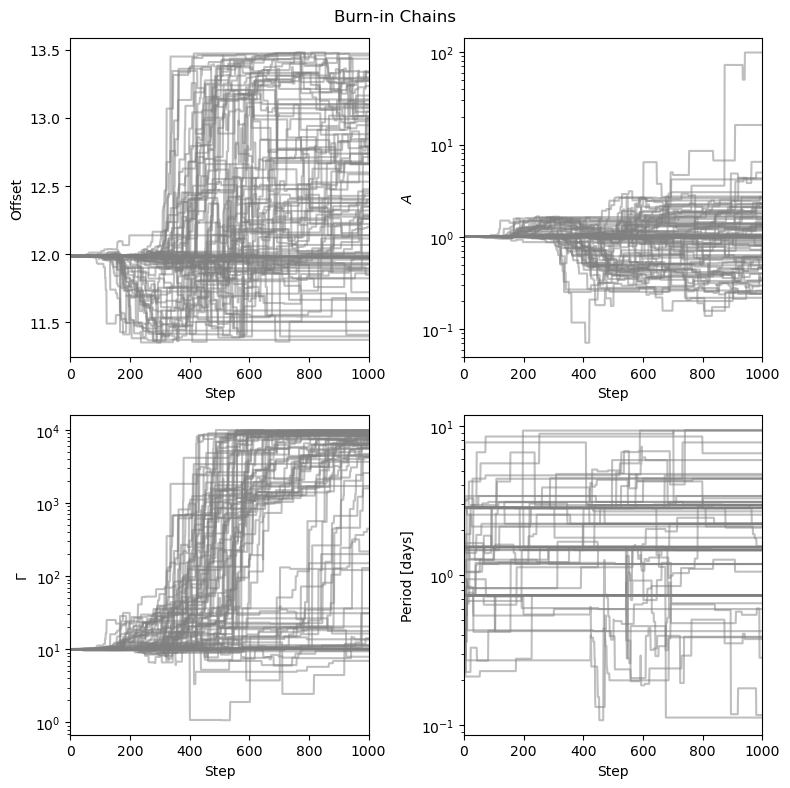

In [50]:
burnin_samples = np.load('burnin_samples.npy')
burnin_samples[:, :, 1] = np.exp(burnin_samples[:, :, 1])
burnin_samples[:, :, 2] = 10**burnin_samples[:, :, 2]
burnin_samples[:, :, 3] = np.exp(burnin_samples[:, :, 3])

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.reshape(axes.size)
fig.suptitle('Burn-in Chains')
names = ('Offset', r'$A$', r'$\Gamma$', r'Period [days]')
for (i, (ax, name)) in enumerate(zip(axes, names)):
    ax.plot(burnin_samples[:, :, i], c='Gray', alpha=0.5)
    ax.set_xlim(0, 1000)
    ax.set_xlabel('Step')
    ax.set_ylabel(name)
for ax in axes[1:]:
    ax.set_yscale('log')
plt.tight_layout()
plt.show()

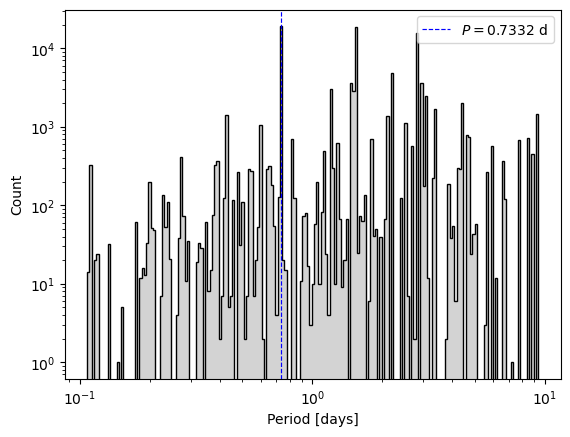

In [51]:
bins = np.geomspace(burnin_samples[:, :, 3].min(), burnin_samples[:, :, 3].max(), 200)
bin_centers = np.sqrt(bins[1:] * bins[:-1])

counts = plt.hist(burnin_samples.reshape((-1, n_dim))[:, 3], bins=bins, histtype='stepfilled', fc='LightGray', ec='Black')[0]
plt.axvline(bin_centers[counts.argmax()], c='Blue', ls='dashed', lw=0.85,
            label=f'$P={bin_centers[counts.argmax()]:.4f}$ d')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Period [days]')
plt.ylabel('Count')
plt.legend()
plt.show()

In [52]:
last_sample = burnin_samples[-1]
last_sample[:, 3] = bin_centers[counts.argmax()]

last_sample[:, 1] = np.log(last_sample[:, 1])
last_sample[:, 2] = np.log10(last_sample[:, 2])
last_sample[:, 3] = np.log(last_sample[:, 3])

last_sample += 1e-3 * rng.standard_normal(last_sample.shape)

n_steps = 1000

with Pool() as pool:
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_prob, args=(tab['MAG'],), pool=pool)
    sampler.run_mcmc(last_sample, n_steps, progress=True)

samples = sampler.get_chain()
np.save('samples.npy', samples)

100%|██████████| 1000/1000 [1:06:33<00:00,  3.99s/it]


In [89]:
samples = np.load('samples.npy')
samples[:, :, 1] = np.exp(samples[:, :, 1])
samples[:, :, 2] = 10**samples[:, :, 2]
samples[:, :, 3] = np.exp(samples[:, :, 3])

### 2c - Infer the model parameters (11 pts)

Plot the chains, the corner plot, the folded lightcurve, the Gaussian process model given the median parameters, 10 other draws from the model and the uncertainty about the model. 


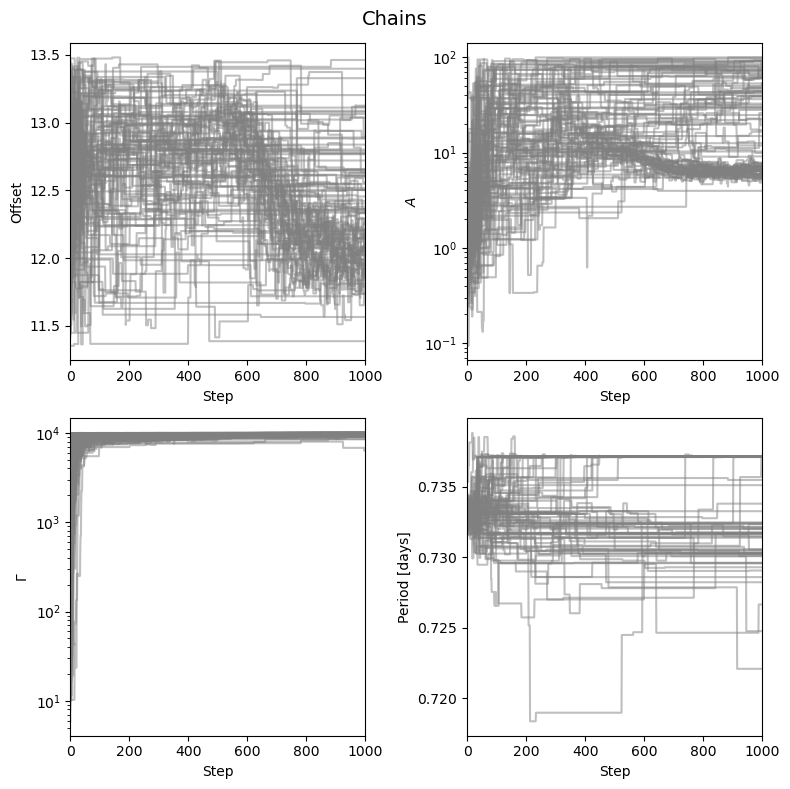

In [91]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.reshape(axes.size)
fig.suptitle('Chains', fontsize=14)
names = ('Offset', '$A$', r'$\Gamma$', 'Period [days]')
for (i, (ax, name)) in enumerate(zip(axes, names)):
    ax.plot(samples[:, :, i], c='Gray', alpha=0.5)
    ax.set_xlabel('Step')
    ax.set_ylabel(name)
    ax.set_xlim(0, 1000)
axes[1].set_yscale('log')
axes[2].set_yscale('log')
plt.tight_layout()
plt.show()

<span style="color: DodgerBlue">

Below, I plot the walkers for $\Gamma$ at steps $100$ and beyond.

</span>

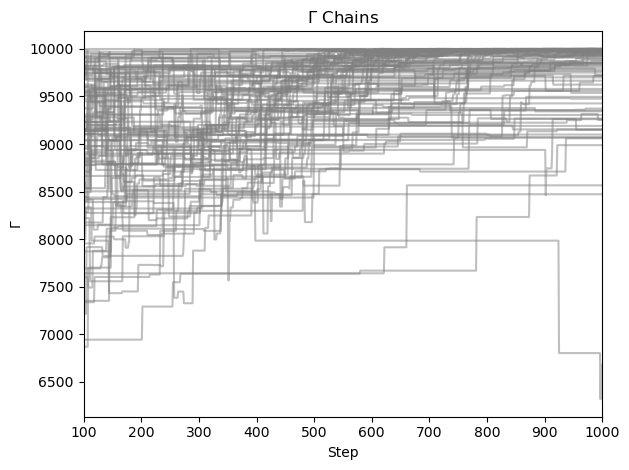

In [92]:
fig, ax = plt.subplots()
ax.plot(range(100, 1000), samples[100:, :, 2], c='Gray', alpha=0.5)
ax.set_xlabel('Step')
ax.set_ylabel(r'$\Gamma$')
ax.set_title(r'$\Gamma$ Chains')
ax.set_xlim(100, 1000)
plt.tight_layout()
plt.show()

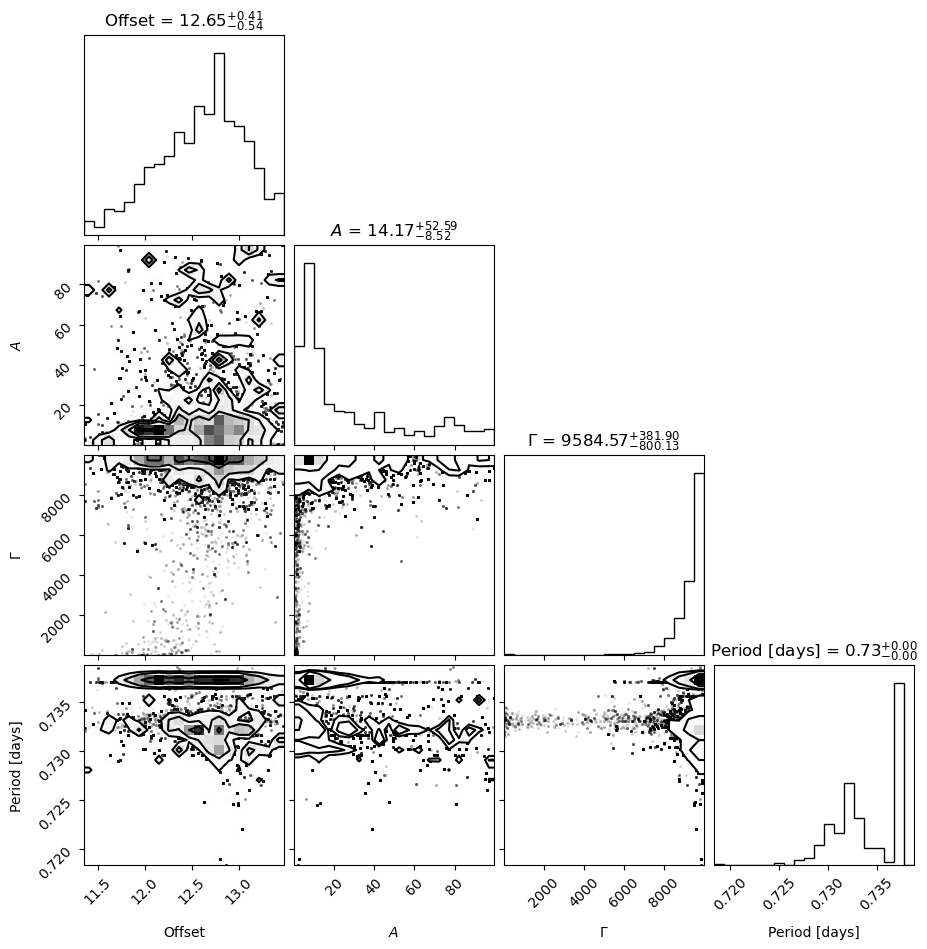

In [93]:
import corner

corner.corner(samples.reshape((-1, n_dim)), labels=names, show_titles=True)
plt.show()

In [101]:
median_params = np.median(samples.reshape((-1, n_dim)), axis=0)
print(f'Median Offset = {median_params[0]:9.4f}')
print(f'Median A      = {median_params[1]:9.4f}')
print(f'Median Gamma  = {median_params[2]:9.4f}')
print(f'Median Period = {median_params[3]:9.4f} d')

Median Offset =   12.6539
Median A      =   14.1671
Median Gamma  = 9584.5659
Median Period =    0.7333 d


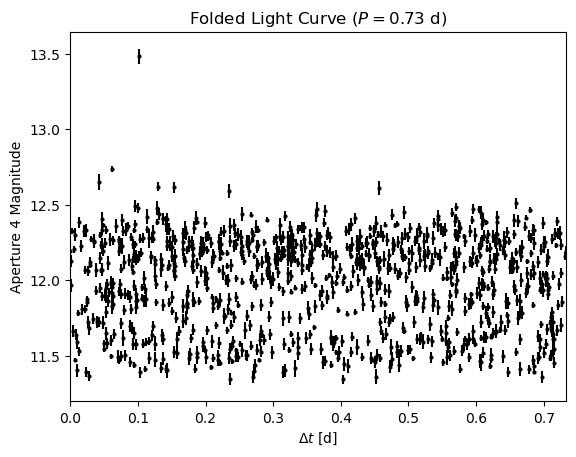

In [123]:
fig, ax = plt.subplots()
ax.errorbar((tab['HJD'] - tab['HJD'].min()) % median_params[3], tab['MAG'], tab['MER'], fmt='o', ms=2, color='Black')
ax.set_xlabel(r'$\Delta t$ [d]')
ax.set_ylabel('Aperture 4 Magnitude')
ax.set_title(f'Folded Light Curve ($P={median_params[3]:.2f}$ d)')
ax.set_xlim(0, median_params[3])
plt.show()

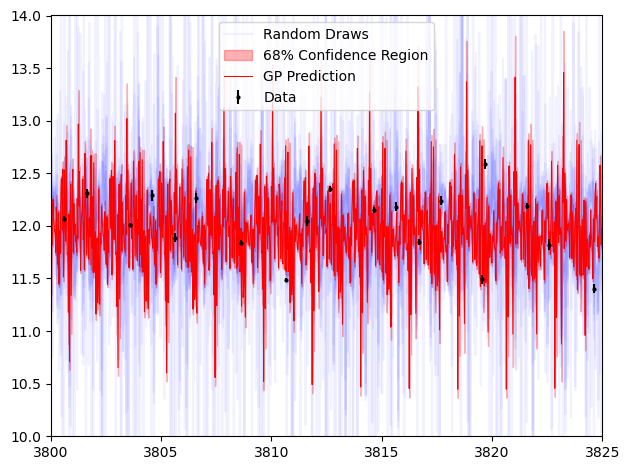

In [139]:
theta = (median_params[0], np.log(median_params[1]), median_params[2], np.log(median_params[3]))
gp.set_parameter_vector(theta)

t_pred = np.linspace(3800, 3825, 1001)
prediction, var = gp.predict(tab['MAG'], t_pred, return_var=True)
std = np.sqrt(var)

fig, ax = plt.subplots()

for i in range(10):
    sample = rng.choice(samples.reshape((-1, n_dim)))
    theta = (sample[0], np.log(sample[1]), sample[2], np.log(sample[3]))
    gp.set_parameter_vector(theta)
    if i == 0:
        ax.plot(t_pred, gp.sample_conditional(tab['MAG'], t_pred), c='Blue', alpha=0.05, label='Random Draws')
    else:
        ax.plot(t_pred, gp.sample_conditional(tab['MAG'], t_pred), c='Blue', alpha=0.05)

ax.fill_between(t_pred, prediction - std, prediction + std, color='Red', label='68% Confidence Region', alpha=0.3)
ax.plot(t_pred, prediction, c='Red', lw=0.75, label='GP Prediction')
ax.errorbar(tab['HJD'], tab['MAG'], tab['MER'], fmt='o', ms=2, color='Black', label='Data')

ax.set_xlim(3800, 3825)
ax.set_ylim(10, 14)

ax.legend()
plt.tight_layout()
plt.show()

N.B. you should be a bit worried about "burn in" and how the walkers were initialized throughout. If you plan to use GPs to search for periods in your own work, I highly recommend you read Angus et al. 2018 on the GP periodogram. Angus et al. provide far more intelligent methods for initializing the MCMC than what is presented here. 

### Q3: PyMC (yes, that thing), hierarchical mixture models, and the mass-radius relation for small exoplanets

The mass-radius relation is a relationship between the radius $R$ of an exoplanet and its mass $M$. We usually call planets smaller than the Neptune size $(R < 4 R_{\oplus})$ small planets. In the Solar System, we don't have any planets between the Earth and Neptune sizes ($ 1-4 R_{\oplus}$), whereas in extrasolar systems, plenty of planets with radii in the range are observed. Thus, it's extremely intriguing to study the compositions of these planets and understand why we don't have one in the Solar System.

In this problem, you will work on one of the papers that one of our colloquium speakers brought up (this is why you should go to colloquium btw, because it'd have totally helped with this final exam to know the answer) - the mass-radius relation for small exoplanets around M-dwarfs. 

The paper is by [Luque et al., Science 377, 1211 (2022)](https://ui.adsabs.harvard.edu/abs/2022arXiv220903871L/abstract). We will reproduce some of their results using the PyMC.

In [5]:
## Download the dataset from Luque et al. 2022
data = pd.read_csv("https://carmenes.caha.es/ext/tmp/TMP.csv")
data.head()

ID  ID_Star      Star          AltName       Karmn     RA_J2000  \
0   1        1   GJ 3053         LHS 1140  J00449-152  00:44:59.33   
1   2        1   GJ 3053         LHS 1140  J00449-152  00:44:59.33   
2   3        2  TOI-1468  LSPM J0106+1913  J01066+192  01:06:36.98   
3   4        2  TOI-1468  LSPM J0106+1913  J01066+192  01:06:36.98   
4   5        3   GJ 3090          TOI-177         NaN  01:21:45.39   

      DE_J2000     SpT  SpTnum    d_pc  ...  eurho_gcm-3  edrho_gcm-3  Teq_K  \
0  -15:16:17.5  M4.5 V     4.5  14.964  ...         0.84         0.80  378.9   
1  -15:16:17.5  M4.5 V     4.5  14.964  ...         0.81         0.74  708.9   
2  +19:13:33.2    M3 V     3.0  24.721  ...         1.05         0.92  682.2   
3  +19:13:33.2    M3 V     3.0  24.721  ...         0.21         0.19  337.5   
4  -46:42:51.8    M2 V     2.0  22.454  ...         0.52         0.45  693.0   

   euTeq_K  edTeq_K     TSM   ESM  Method  DiscoveryRef       ParameterRef  
0      4.3      4.2    8.88  0.19      RV         Dit17  Dit17 Men19 Lil20  
1      8.0      7.8   25.90  3.45      RV         Dit17  Dit17 Men19 Lil20  
2      7.4      6.9    9.00  6.30      RV         Cha22              Cha22  
3      3.7      3.4   59.00   NaN      RV         Cha22              Cha22  
4     18.0     18.0  221.00   NaN      RV        Alm22a             Alm22a  

[5 rows x 44 columns]

In [29]:
print(data.columns)

Index(['ID', 'ID_Star', 'Star', 'AltName', 'Karmn', 'RA_J2000', 'DE_J2000',
       'SpT', 'SpTnum', 'd_pc', 'ed_pc', 'Lbol_Lsol', 'eLbol_Lsol', 'Teff_K',
       'eTeff_K', 'R_Rsol', 'eR_Rsol', 'M_Msol', 'eM_Msol', 'J_mag', 'eJ_mag',
       'Ks_mag', 'eKs_mag', 'Planet', 'TOI', 'Porb_d', 'a_au', 'R_Rterra',
       'euR_Rterra', 'edR_Rterra', 'M_Mterra', 'euM_Mterra', 'edM_Mterra',
       'rho_gcm-3', 'eurho_gcm-3', 'edrho_gcm-3', 'Teq_K', 'euTeq_K',
       'edTeq_K', 'TSM', 'ESM', 'Method', 'DiscoveryRef', 'ParameterRef'],
      dtype='object')


In [7]:
## Lets extract mass and radius and their uncertainties from the data; both M and R are in Earth units 
M = data.M_Mterra
R = data.R_Rterra

err_M = (data.edM_Mterra + data.euM_Mterra) / 2  # Assume the + and - errors on M and R are symmetric because lazy
err_R = (data.edR_Rterra + data.euR_Rterra) / 2

ind = (err_R < 1)
M = M[ind]
R = R[ind]
err_M = err_M[ind]
err_R = err_R[ind]

c = data['rho_gcm-3'][ind]

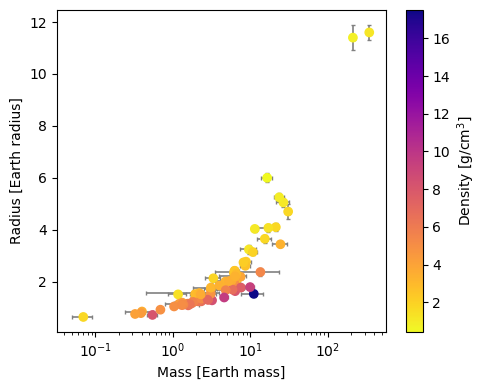

In [8]:
## Plot the mass and radius of small planets around M-dwarfs
plt.figure(figsize=(5, 4))
plt.errorbar(M, R, xerr=err_M, yerr=err_R, ls='none', fmt='o', ms=4, elinewidth=1.2, capsize=1.2, c='Gray')
plt.scatter(M, R, c=c, zorder=100, cmap='plasma_r')
plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.colorbar(label=r'Density [g/cm$^3$]')
plt.tight_layout()
plt.show()

Exoplaneteers made up cute names to describe planets in different compositions.
- "Rocky world" if a planet has a bulk density similar to the Earth.
- "Water world" if a planet has a bulk density consistent with 50% rocky and 50% water ice.
- "Puffy world" if a planet has a bulk density smaller than the "Water World" density.

Now, while it's possible that this final is making you wish you were on a "puff" of something or the other, we'll restrict our analysis to the rocky and water worlds. It's where the grant dollars are. 


### 3a - modeling the mass radius relation for rocky worlds (11 pts) 

First, select the rocky worlds. 

Let's write down the mass-radius relation for rocky worlds as a power law.

$R = aM^b$, where $a$ is proportional to $1/\rho_{\oplus}$, and $b$ is unitless. If the relation follows $M = \frac{4}{3}\pi R^3 \rho$, we have $a = 1$ and $b = 1/3$. However, in reality, the interior density of planets is not uniform and depends on the equation of state.

Build a PyMC model to find parameters of interest {a, b}. Plot the traces (`pm` has a `plot_trace` function)and inferred model, along with some draws.

Hints:
- As a, b have to be positive, I'd suggest Uniform priors on log a, log b, and then using pm.Deterministic to exponentiate them 
- For the masses, since you've selected the rocky worlds, I'd suggest a normal distribution with the sample mean and sample standard deviation of the rocky worlds. 
- Given M, a, b you can use pm.Deterministic to get R_model
- Assume our favorite normal likelihood for R_model. You have the observed radius and their uncertainties from the file.

In [9]:
import pymc as pm

In [10]:
R_err = (data['edR_Rterra'] + data['euR_Rterra']) / 2
data = data[R_err < 1]

<span style="color: DodgerBlue">

I will use a cutoff density of $0.65\rho_{\oplus}$, as found in the paper, to select rocky planets.

The relation $R=aM^{b}$ is equivalent to $\log R=\log a+b\log M$, so I plot $\log R$ against $\log M$ below.

</span>

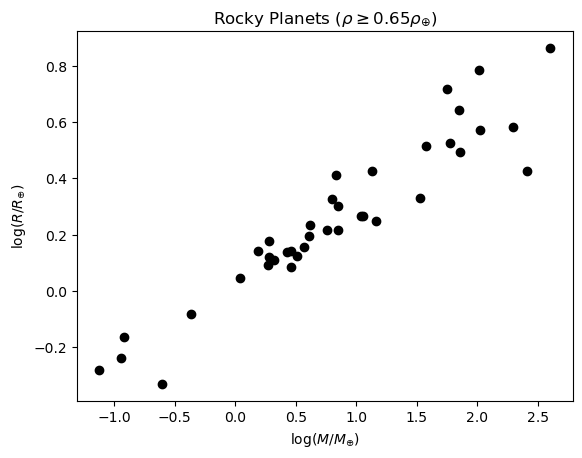

In [11]:
rho_Earth = 5.515  # g/cm^3
rocky_inds = (data['rho_gcm-3'] >= 0.65 * rho_Earth)
rocky_planets = data[rocky_inds]

M_rocky = rocky_planets['M_Mterra'].to_numpy()
R_rocky = rocky_planets['R_Rterra'].to_numpy()
M_rocky_err = ((rocky_planets['edM_Mterra'] + rocky_planets['euM_Mterra']) / 2).to_numpy()
R_rocky_err = ((rocky_planets['edR_Rterra'] + rocky_planets['euR_Rterra']) / 2).to_numpy()
rho_rocky = rocky_planets['rho_gcm-3']

fig, ax = plt.subplots()
ax.scatter(np.log(M_rocky), np.log(R_rocky), c='Black')
ax.set_xlabel(r'$\log(M/M_{\oplus})$')
ax.set_ylabel(r'$\log(R/R_{\oplus})$')
ax.set_title(r'Rocky Planets ($\rho\geq0.65\rho_{\oplus}$)')
plt.show()

<span style="color: DodgerBlue">

From this plot, I can estimate that $\log s\approx0$ and $b\approx0.25$ ($\log b\approx-1.4$). I can get a more rigorous guess by fitting a line:

</span>

In [12]:
log_M_rocky = np.log(M_rocky)
log_R_rocky = np.log(R_rocky)

cov = np.cov([log_M_rocky, log_R_rocky])
b_est = cov[0, 1] / cov[0, 0]
log_a_est = log_R_rocky.mean() - b_est * log_M_rocky.mean()

print(log_a_est, b_est)

0.02507623287459529 0.2829569667332176


<span style="color: DodgerBlue">

I will therefore impose $-1\leq\log a\leq1$ and $-3\leq\log b\leq0$.

</span>

In [13]:
with pm.Model() as model:
    # Priors
    log_a = pm.Uniform('log_a', lower=-1, upper=1)
    log_b = pm.Uniform('log_b', lower=-3, upper=0)
    
    a = pm.Deterministic('a', pm.math.exp(log_a))
    b = pm.Deterministic('b', pm.math.exp(log_b))
    
    R_model = pm.Deterministic('R_model', a * M_rocky**b)
    likelihood = pm.Normal('likelihood', mu=R_model, sigma=R_rocky_err, observed=R_rocky)
    
    idata = pm.sample(tune=500, draws=5000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_a, log_b]


Sampling 4 chains for 500 tune and 5_000 draw iterations (2_000 + 20_000 draws total) took 35 seconds.


In [14]:
idata_summary = pm.summary(idata)
idata_summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
log_a        0.027  0.004   0.019    0.035        0.0      0.0   18546.0   
log_b       -1.259  0.018  -1.292   -1.224        0.0      0.0   17561.0   
a            1.028  0.004   1.020    1.036        0.0      0.0   18546.0   
b            0.284  0.005   0.274    0.294        0.0      0.0   17561.0   
R_model[0]   1.740  0.016   1.711    1.770        0.0      0.0   18381.0   
R_model[1]   1.207  0.005   1.197    1.217        0.0      0.0   19207.0   
R_model[2]   1.432  0.009   1.416    1.448        0.0      0.0   18742.0   
R_model[3]   1.739  0.016   1.709    1.768        0.0      0.0   18383.0   
R_model[4]   1.307  0.006   1.294    1.319        0.0      0.0   19014.0   
R_model[5]   1.387  0.008   1.372    1.402        0.0      0.0   18823.0   
R_model[6]   1.162  0.005   1.153    1.171        0.0      0.0   19146.0   
R_model[7]   1.827  0.018   1.793    1.860        0.0      0.0   18326.0   
R_model[8]   1.170  0.005   1.162    1.180        0.0      0.0   19173.0   
R_model[9]   1.170  0.005   1.162    1.180        0.0      0.0   19173.0   
R_model[10]  1.276  0.006   1.264    1.287        0.0      0.0   19088.0   
R_model[11]  1.416  0.008   1.400    1.432        0.0      0.0   18764.0   
R_model[12]  1.226  0.005   1.216    1.236        0.0      0.0   19189.0   
R_model[13]  0.792  0.006   0.781    0.803        0.0      0.0   17730.0   
R_model[14]  1.289  0.006   1.277    1.301        0.0      0.0   19056.0   
R_model[15]  1.691  0.014   1.664    1.718        0.0      0.0   18422.0   
R_model[16]  1.821  0.018   1.787    1.854        0.0      0.0   18330.0   
R_model[17]  1.222  0.005   1.212    1.232        0.0      0.0   19194.0   
R_model[18]  0.865  0.005   0.855    0.875        0.0      0.0   18005.0   
R_model[19]  1.702  0.015   1.674    1.729        0.0      0.0   18412.0   
R_model[20]  1.187  0.005   1.178    1.197        0.0      0.0   19218.0   
R_model[21]  1.309  0.006   1.296    1.320        0.0      0.0   19011.0   
R_model[22]  2.037  0.024   1.991    2.080        0.0      0.0   18234.0   
R_model[23]  1.380  0.008   1.365    1.394        0.0      0.0   18839.0   
R_model[24]  2.153  0.027   2.100    2.202        0.0      0.0   18199.0   
R_model[25]  1.085  0.004   1.077    1.093        0.0      0.0   18811.0   
R_model[26]  1.607  0.012   1.584    1.631        0.0      0.0   18491.0   
R_model[27]  1.302  0.006   1.290    1.314        0.0      0.0   19027.0   
R_model[28]  1.112  0.004   1.104    1.121        0.0      0.0   18936.0   
R_model[29]  1.974  0.022   1.933    2.015        0.0      0.0   18259.0   
R_model[30]  1.125  0.005   1.117    1.134        0.0      0.0   19000.0   
R_model[31]  1.109  0.004   1.101    1.118        0.0      0.0   18922.0   
R_model[32]  0.785  0.006   0.774    0.796        0.0      0.0   17705.0   
R_model[33]  0.926  0.005   0.917    0.935        0.0      0.0   18214.0   
R_model[34]  1.039  0.004   1.031    1.047        0.0      0.0   18591.0   
R_model[35]  1.112  0.004   1.104    1.121        0.0      0.0   18937.0   
R_model[36]  0.748  0.006   0.736    0.759        0.0      0.0   17608.0   
R_model[37]  1.586  0.012   1.563    1.608        0.0      0.0   18517.0   

             ess_tail  r_hat  
log_a         14822.0    1.0  
log_b         14004.0    1.0  
a             14822.0    1.0  
b             14004.0    1.0  
R_model[0]    14216.0    1.0  
R_model[1]    14985.0    1.0  
R_model[2]    14954.0    1.0  
R_model[3]    14216.0    1.0  
R_model[4]    15098.0    1.0  
R_model[5]    15093.0    1.0  
R_model[6]    15431.0    1.0  
R_model[7]    14091.0    1.0  
R_model[8]    15400.0    1.0  
R_model[9]    15400.0    1.0  
R_model[10]   15397.0    1.0  
R_model[11]   14928.0    1.0  
R_model[12]   15151.0    1.0  
R_model[13]   13428.0    1.0  
R_model[14]   15122.0    1.0  
R_model[15]   14242.0    1.0  
R_model[16]   14091.0    1.0  
R_model[17]   15009.0    1.0  
R_model[18]   13552.0    1.0  
R

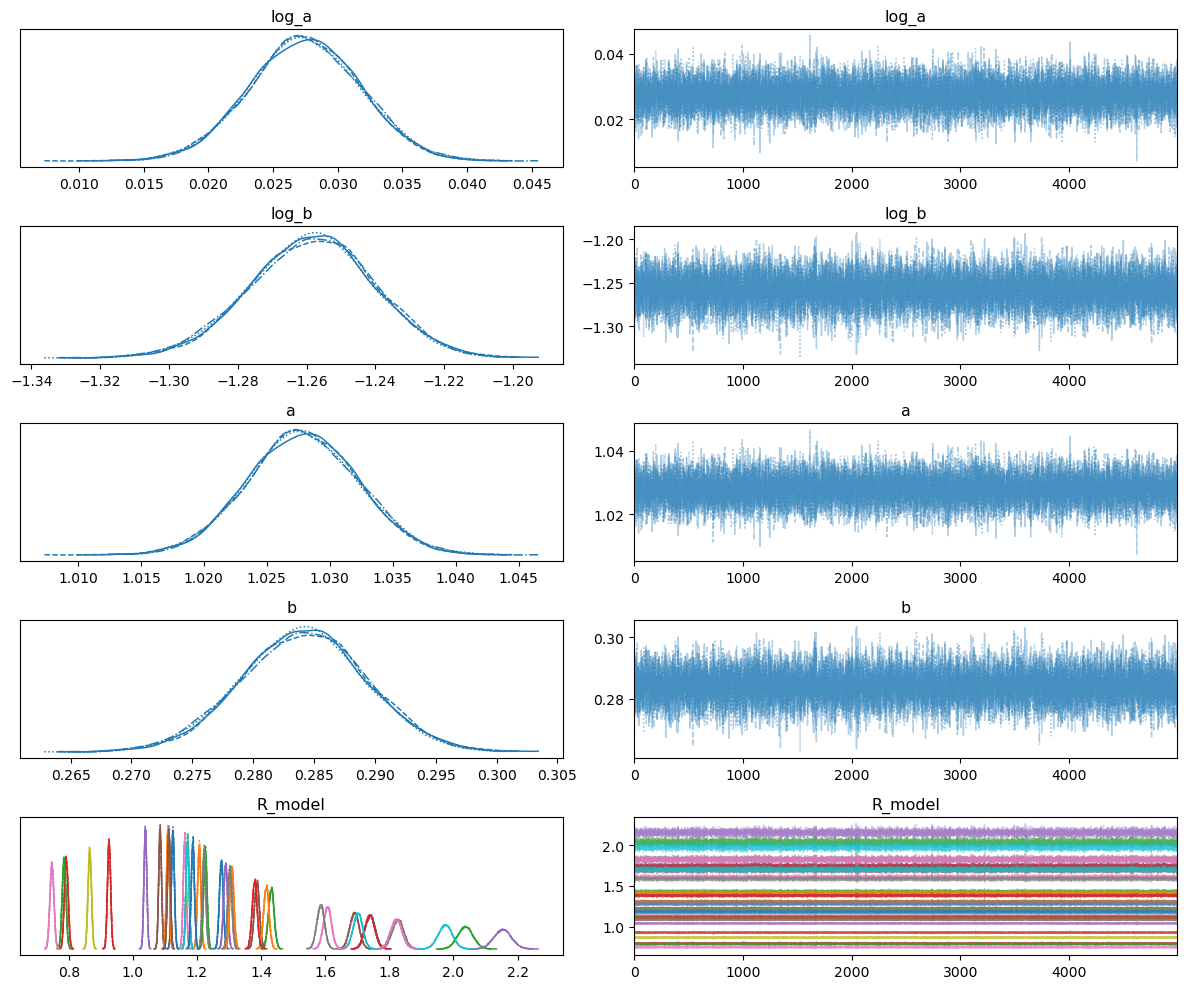

In [15]:
pm.plot_trace(idata)
plt.tight_layout()
plt.show()

In [16]:
samples = np.empty((len(idata.posterior.chain), len(idata.posterior.draw), 2))
samples[:, :, 0] = idata.posterior['a']
samples[:, :, 1] = idata.posterior['b']
samples = samples.reshape((-1, 2))

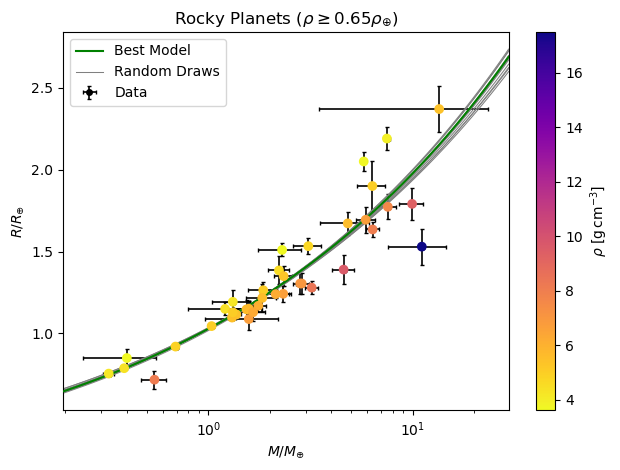

In [19]:
rng = np.random.default_rng(42)

# Create figure
fig, ax = plt.subplots()

# Plot the data points
ax.errorbar(M_rocky, R_rocky, xerr=M_rocky_err, yerr=R_rocky_err,
            ls='none', fmt='o', ms=4, elinewidth=1.2, capsize=1.2, c='Black', label='Data')
scatterplot = ax.scatter(M_rocky, R_rocky, c=rho_rocky, cmap='plasma_r', zorder=100)
plt.colorbar(scatterplot, label=r'$\rho$ [$\rm g\,cm^{-3}$]', ax=ax)

# Plot the best model
ax.set_xscale('log')
xlim = ax.get_xlim()
M_plot = np.geomspace(*xlim, 101)
R_plot = idata_summary.loc['a']['mean'] * M_plot**idata_summary.loc['b']['mean']
ax.plot(M_plot, R_plot, c='Green', label='Best Model', zorder=3)

# Plot models associated with 10 random draws from the posterior
for i in range(10):
    a, b = rng.choice(samples)
    if i == 0:
        ax.plot(M_plot, a * M_plot**b, c='Gray', lw=0.75, label='Random Draws')
    else:
        ax.plot(M_plot, a * M_plot**b, c='Gray', lw=0.75)

ax.set_xlim(*xlim)
ax.set_title(r'Rocky Planets ($\rho\geq0.65\rho_{\oplus}$)')
ax.set_xlabel(r'$M/M_{\oplus}$')
ax.set_ylabel(r'$R/R_{\oplus}$')
ax.legend()
plt.tight_layout()

plt.show()

### 3b - The Mass-Radius Relation for Rocky+Water Worlds (23 pts) 

Let's now add water worlds and model the mass-radius relation for both rocky and water worlds. Physically, it will require two models to describe the mass-radius relations for rocky and water worlds. The tricky part is we don't know exactly which kind of worlds a planet is belong to. In this situation, it is helpful to introduce a categorical variable `z` that is either 0 or 1, with the relative posterior probabilities telling us how Rocky/Watery a planet is.

Select the Rocky Water worlds - see the categories above 3a again. 

To make this work like magic with PyMC and it's Monte-Carlo sampler, we can choose a special prior for our categorial variable: the Drichlet Prior - https://en.wikipedia.org/wiki/Dirichlet_distribution

    # Two categories for water and rocky worlds
    p = pm.Dirichlet("p", a=np.ones(2), shape=2)
    z = pm.Categorical("z", p=p, shape=len(RockyWaterWorlds))
    

The rest of the PyMC model should be the same as 3a except you are fitting two relations - one for rocky worlds and one for water worlds, so you need two different `a` and `b` parameters - `shape=2` as above should take it. You might want to sort the `a` parameter with `transform=pm.distributions.transforms.ordered` when you define the prior to sort things. 

Build a PyMC model to find parameters of interest {a, b}. Plot the traces (`pm` has a `plot_trace` function)and inferred model, along with some draws.

<span style="color: DodgerBlue">

I will define a lower density cutoff of $0.4\rho_{\oplus}$ for water worlds, read roughly from Fig. 1B of the paper.

As before, I plot $\log R$ against $\log M$ to estimate the parameters of the mass-radius relation for water worlds.

</span>

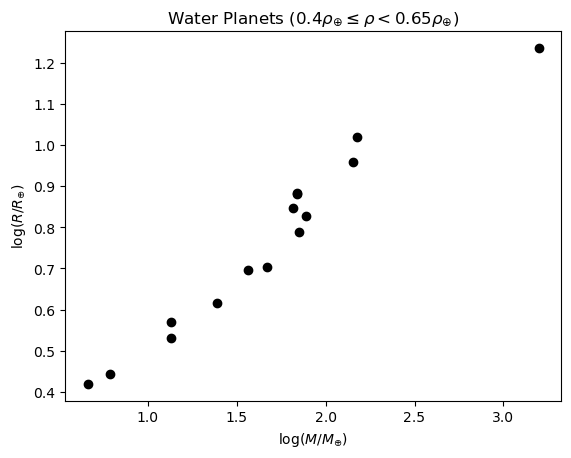

In [20]:
# Define water planets
water_inds = (data['rho_gcm-3'] >= 0.4 * rho_Earth) & ~rocky_inds
water_planets = data[water_inds]

M_water = water_planets['M_Mterra'].to_numpy()
R_water = water_planets['R_Rterra'].to_numpy()
M_water_err = ((water_planets['edM_Mterra'] + water_planets['euM_Mterra']) / 2).to_numpy()
R_water_err = ((water_planets['edR_Rterra'] + water_planets['euR_Rterra']) / 2).to_numpy()
rho_water = water_planets['rho_gcm-3']

# Select both rocky and water planets
rockywater_planets = data[rocky_inds | water_inds]
M_rockywater = rockywater_planets['M_Mterra'].to_numpy()
R_rockywater = rockywater_planets['R_Rterra'].to_numpy()
M_rockywater_err = ((rockywater_planets['edM_Mterra'] + rockywater_planets['euM_Mterra']) / 2).to_numpy()
R_rockywater_err = ((rockywater_planets['edR_Rterra'] + rockywater_planets['euR_Rterra']) / 2).to_numpy()
rho_rockywater = rockywater_planets['rho_gcm-3']

# Plot distribution of water planets in M-R space
fig, ax = plt.subplots()
ax.scatter(np.log(M_water), np.log(R_water), c='Black')
ax.set_xlabel(r'$\log(M/M_{\oplus})$')
ax.set_ylabel(r'$\log(R/R_{\oplus})$')
ax.set_title(r'Water Planets ($0.4\rho_{\oplus}\leq\rho<0.65\rho_{\oplus}$)')
plt.show()

<span style="color: DodgerBlue">

I can estimate $b\approx1/3$ ($\log b\approx-1.1$) and $\log a\approx0.2$, and a linear fit agrees:

</span>

In [21]:
log_M_water = np.log(M_water)
log_R_water = np.log(R_water)

cov = np.cov([log_M_water, log_R_water])
b_est = cov[0, 1] / cov[0, 0]
log_a_est = log_R_water.mean() - b_est * log_M_water.mean()

print(log_a_est, b_est)

0.1714737050638797 0.3527772812322237


<span style="color: DodgerBlue">

I will impose the same priors as before ($-1\leq\log a\leq1$ and $-3\leq\log b\leq0$) since they are appropriate for both types of planets.

</span>

In [22]:
with pm.Model() as model:
    log_a = pm.Uniform('log_a', lower=-1, upper=1, shape=2)
    log_b = pm.Uniform('log_b', lower=-3, upper=0, shape=2)
    
    a = pm.Deterministic('a', pm.math.exp(log_a))
    b = pm.Deterministic('b', pm.math.exp(log_b))
    
    # Two categories for water and rocky worlds
    p = pm.Dirichlet('p', a=np.ones(2), shape=2)
    z = pm.Categorical('z', p=p, shape=len(rockywater_planets))
    
    R_model = pm.Deterministic('R_model', (1 - z) * a[0] * M_rockywater**b[0] + z * a[1] * M_rockywater**b[1])
    likelihood = pm.Normal('likelihood', mu=R_model, sigma=R_rockywater_err, observed=R_rockywater)
    
    idata = pm.sample(tune=500, draws=5000, random_seed=42)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [log_a, log_b, p]
CompoundStep
>NUTS: [log_a, log_b, p]
>BinaryGibbsMetropolis: [z]


Sampling 4 chains for 500 tune and 5_000 draw iterations (2_000 + 20_000 draws total) took 158 seconds.
/Users/mustafamemon/miniconda3/envs/astr596/lib/python3.10/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [23]:
idata_summary = pm.summary(idata)
idata_summary

/Users/mustafamemon/miniconda3/envs/astr596/lib/python3.10/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/mustafamemon/miniconda3/envs/astr596/lib/python3.10/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/mustafamemon/miniconda3/envs/astr596/lib/python3.10/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/mustafamemon/miniconda3/envs/astr596/lib/python3.10/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
z[0]         0.000  0.000   0.000    0.000      0.000    0.000   20000.0   
z[1]         0.004  0.059   0.000    0.000      0.001    0.000   11917.0   
z[2]         0.000  0.000   0.000    0.000      0.000    0.000   20000.0   
z[3]         0.280  0.449   0.000    1.000      0.004    0.002   16433.0   
z[4]         1.000  0.000   1.000    1.000      0.000    0.000   20000.0   
...            ...    ...     ...      ...        ...      ...       ...   
R_model[48]  0.926  0.008   0.911    0.941      0.000    0.000    4705.0   
R_model[49]  1.036  0.009   1.022    1.055      0.000    0.000   12994.0   
R_model[50]  1.112  0.022   1.090    1.158      0.000    0.000    4612.0   
R_model[51]  0.760  0.009   0.743    0.776      0.000    0.000   10841.0   
R_model[52]  1.524  0.015   1.495    1.553      0.000    0.000    4442.0   

             ess_tail  r_hat  
z[0]          20000.0    NaN  
z[1]          11917.0    1.0  
z[2]          20000.0    NaN  
z[3]          16433.0    1.0  
z[4]          20000.0    NaN  
...               ...    ...  
R_model[48]    7401.0    1.0  
R_model[49]   12877.0    1.0  
R_model[50]    8694.0    1.0  
R_model[51]    7550.0    1.0  
R_model[52]    8502.0    1.0  

[116 rows x 9 columns]

In [24]:
idata_summary.loc[['a[0]', 'a[1]', 'b[0]', 'b[1]']][['mean', 'sd']]

mean     sd
a[0]  1.022  0.006
a[1]  1.073  0.045
b[0]  0.262  0.006
b[1]  0.390  0.021

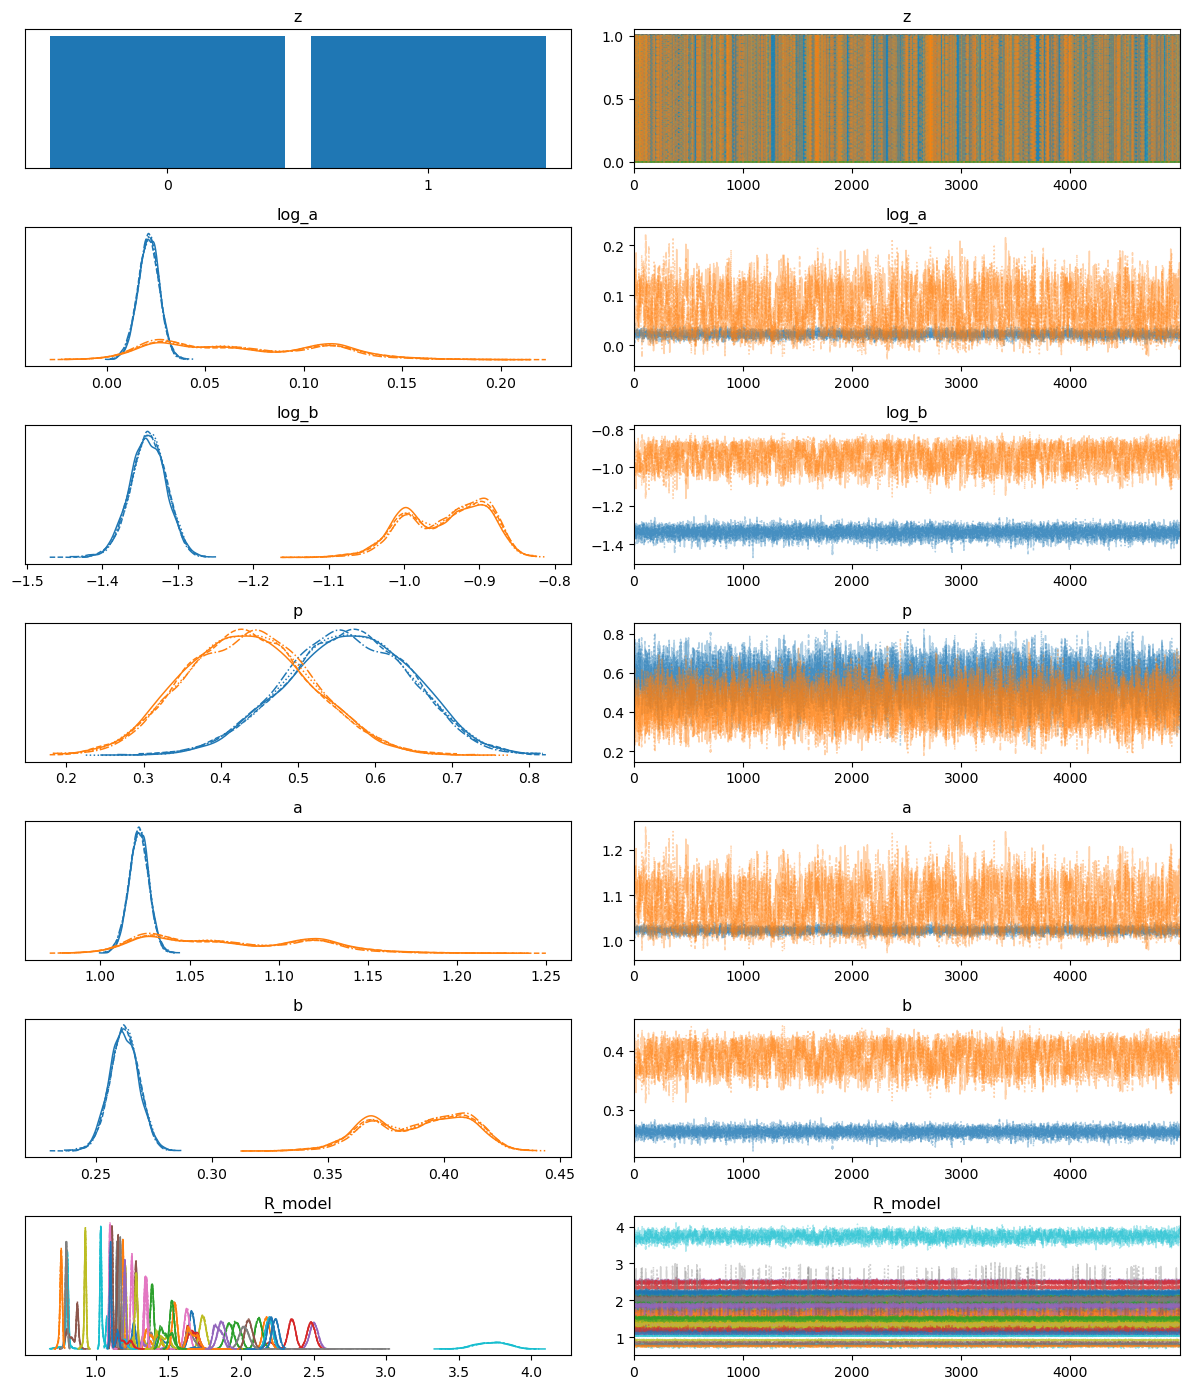

In [25]:
pm.plot_trace(idata)
plt.tight_layout()
plt.show()

In [26]:
samples = np.empty((len(idata.posterior.chain), len(idata.posterior.draw), 4))
samples[:, :, 0] = idata.posterior['a'][:, :, 0]
samples[:, :, 1] = idata.posterior['b'][:, :, 0]
samples[:, :, 2] = idata.posterior['a'][:, :, 1]
samples[:, :, 3] = idata.posterior['b'][:, :, 1]
samples = samples.reshape((-1, 4))

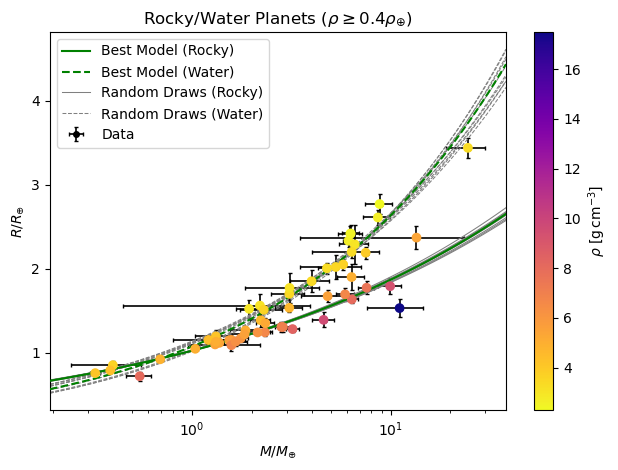

In [28]:
rng = np.random.default_rng(42)

# Create figure
fig, ax = plt.subplots()

# Plot the data points
ax.errorbar(M_rockywater, R_rockywater, xerr=M_rockywater_err, yerr=R_rockywater_err,
            ls='none', fmt='o', ms=4, elinewidth=1.2, capsize=1.2, c='Black', label='Data')
scatterplot = ax.scatter(M_rockywater, R_rockywater, c=rho_rockywater, cmap='plasma_r', zorder=100)
plt.colorbar(scatterplot, label=r'$\rho$ [$\rm g\,cm^{-3}$]', ax=ax)

# Plot the best model
ax.set_xscale('log')
xlim = ax.get_xlim()
M_plot = np.geomspace(*xlim, 101)
R_plot_r = idata_summary.loc['a[0]']['mean'] * M_plot**idata_summary.loc['b[0]']['mean']
R_plot_w = idata_summary.loc['a[1]']['mean'] * M_plot**idata_summary.loc['b[1]']['mean']
ax.plot(M_plot, R_plot_r, c='Green', label='Best Model (Rocky)', zorder=3)
ax.plot(M_plot, R_plot_w, c='Green', label='Best Model (Water)', zorder=3, ls='dashed')

# Plot models associated with 10 random draws from the posterior
for i in range(10):
    a_r, b_r, a_w, b_w = rng.choice(samples)
    if i == 0:
        ax.plot(M_plot, a_r * M_plot**b_r, c='Gray', lw=0.75, label='Random Draws (Rocky)')
        ax.plot(M_plot, a_w * M_plot**b_w, c='Gray', lw=0.75, label='Random Draws (Water)', ls='dashed')
    else:
        ax.plot(M_plot, a_r * M_plot**b_r, c='Gray', lw=0.75)
        ax.plot(M_plot, a_w * M_plot**b_w, c='Gray', lw=0.75, ls='dashed')

ax.set_xlim(*xlim)
ax.set_title(r'Rocky/Water Planets ($\rho\geq0.4\rho_{\oplus}$)')

ax.set_xlabel(r'$M/M_{\oplus}$')
ax.set_ylabel(r'$R/R_{\oplus}$')
ax.legend()
plt.tight_layout()

plt.show()

### Throughout, make sure your plots have things like appropriate axes scales, axes labels, errorsbars, legends, reasonable colors. Remember, these are how you tell the story of what you've done, and ultimately what we're looking at.  


### Get started. You know how to do all of this. If not, there's something in a class notebook that can help. I'm on Teams, so direct questions there. 

# Best of luck. You've got this. 